<a href="https://colab.research.google.com/github/morales-cmd/Drinking-influence-on-on-line-handwritten-signature/blob/main/Signature_drinking_reasearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature extraction data

In [2]:
import numpy as np
import cv2
import librosa, librosa.display
import pandas as pd
import os
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [3]:
v1=[7,10]
v2=[4,5]
np.dot(np.array(v1),np.array(v2))
np.linalg.norm(v1)

12.206555615733702

In [6]:
# euclidean distnace between 2 points (input 2 points)
def distance(curpoint,prevpoint):
  return np.sqrt((curpoint[0]-prevpoint[0])**2+(curpoint[1]-prevpoint[1])**2)

# return acc stats (min,max, mean, zerocrossings) stat (input non-stationary points with vel and acc)
def acceleration_stats(points):
  arr=np.array(points)
  arr=np.transpose(arr)
  zero_crossings = librosa.zero_crossings(arr[6], pad=False)
  return(min(arr[6]),max(arr[6]),np.mean(arr[6]),sum(zero_crossings))

# return vector with acc/dur stat (input non-stationary points with vel and acc)
def acceleration_by_duration(points):
  sum=0
  for i in range(1,len(points)):
    if(points[i][6]>0):
      sum+= points[i][4]-points[i-1][4]
  dur=points[len(points)-1][4]-points[0][4]
  return sum/dur

# return vector with all strokes durations (input non-stationary points)
def calc_vel_acc(points):
  points[0].append(0)  #0 velocity at 1st point
  points[0].append(0)  #0 acceleration at 1st point

  for i in range(1,len(points)):
    dist=distance(points[i],points[i-1])
    velocity= dist/(points[i][4]-points[i-1][4])
    points[i].append(velocity)
    acceleration=(points[i][5]-points[i-1][5])/(points[i][4]-points[i-1][4])
    points[i].append(acceleration)

def angle(v1,v2):
  return np.arccos(np.dot(np.array(v1),np.array(v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)))


def calc_dir_change_vel(points):
  points[0].append(0)  #0 velocity at 1st point
  points[1].append(0)  #0 acceleration at 1st point

  for i in range(2,len(points)):
    v1=[points[i][0]-points[i-1][0],points[i][1]-points[i-1][1]]
    v2=[points[i-1][0]-points[i-2][0],points[i-1][1]-points[i-2][1]]

    ang=angle(v1,v2);
    velocity= ang/(points[i][4]-points[i-1][4])
    # print(velocity)
    points[i].append(velocity)
    # acceleration=(points[i][5]-points[i-1][5])/(points[i][4]-points[i-1][4])
    # points[i].append(acceleration)

def dir_vel_stats(points):
  arr=np.array(points)
  arr=np.transpose(arr)
  # print(np.nanmean(arr[7]))
  return np.nanmean(arr[7])

# return vector with all strokes durations (input all points)
def stroke_dur(points):
  strokes_durs=[]
  start=points[0][4]
  for i in range(1,len(points)):
    if(points[i][3]>0 and points[i-1][3]==0):
      start=points[i][4]
    if(points[i][3]==0 and points[i-1][3]>0):
      strokes_durs.append(points[i][4]-start)
  return strokes_durs

# return vector with all strokes lengths (input all points)
def stroke_len(points):
  strokes_lens=[]
  sum=0
  if points[0][3]>0:
    start=1
  else:
    start=0
  for i in range(1,len(points)):
    if(points[i][3]>0 and points[i-1][3]==0):
      start=1
    if(points[i][3]==0 and points[i-1][3]>0):
      start=0
      strokes_lens.append(sum)
      sum=0
    if(start==1):
      sum+=distance(points[i],points[i-1])
  return strokes_lens

def average_stroke_press(points):
  strokes_press=[]
  it = 0
  sum = 0
  if points[0][3]>0:
    start=1
  else:
    start=0
  for i in range(1,len(points)):
    if(points[i][3]>0 and points[i-1][3]==0):
      it=0
      sum=0
      start=1
    if(points[i][3]==0 and points[i-1][3]>0):
      start=0
      strokes_press.append(sum/it)
    if(start==1):
      sum+=points[i][3]
      it+=1
  return strokes_press

#visualization of signature
def vizualization(points):
  im=np.zeros((300,300))
  for p in points:
    im[200-int(p[1]),int(p[0])]=255
  cv2_imshow(im)




# remove points with no x and y changes or no time changes
def remove_stationary_points(points):
  new_points=[]
  for i in range(1,len(points)):
    if((points[i][0]!=points[i-1][0] or points[i][1]!=points[i-1][1])and (points[i][4]!=points[i-1][4])):
      new_points.append(points[i])
  return new_points
def remove_noisy_points(points):
  new_points=[]
  for i in range(1,len(points)-1):
    if(~(points[i][3]==0 and points[i-1][3]>0 and points[i+1][3]>0)):
      new_points.append(points[i])
  return new_points

class Signature_features:
  def __init__(self, acc_by_dur, m_str_dur,std_str_dur,m_str_len,std_str_len, acc_stats,m_press,std_press):
    self.acc_by_dur = acc_by_dur
    self.m_str_dur = m_str_dur
    self.std_str_dur=std_str_dur
    self.m_str_len = m_str_len
    self.std_str_len=std_str_len
    self.acc_stats = acc_stats
    self.m_press= m_press
    self.std_press=std_press

def get_stats(lines):
  points=[]
  for l in lines:
    a=l.replace("\n","")
    a=a.split(", ")
    a=[float(numeric_string) for numeric_string in a]
    points.append(a)
  vizualization(points)
  points_reduced=remove_stationary_points(points)
  points_filtered=remove_noisy_points(points)
  calc_vel_acc(points_reduced)
  calc_dir_change_vel(points_reduced)
  return [acceleration_by_duration(points_reduced), np.mean(stroke_dur(points_filtered)),np.std(stroke_dur(points_filtered)), np.mean(stroke_len(points_filtered)), np.std(stroke_len(points_filtered)), acceleration_stats(points_reduced)[0],acceleration_stats(points_reduced)[1],acceleration_stats(points_reduced)[2],acceleration_stats(points_reduced)[3],np.mean(average_stroke_press(points_filtered)), np.std(average_stroke_press(points_filtered)),dir_vel_stats(points_reduced)]

def read_signature(path):
  with open(path) as f:
    lines = f.readlines()
  return lines

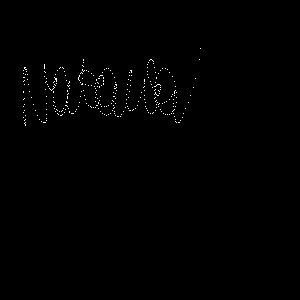

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in arccos


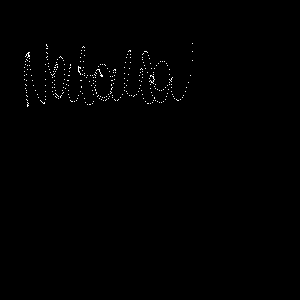

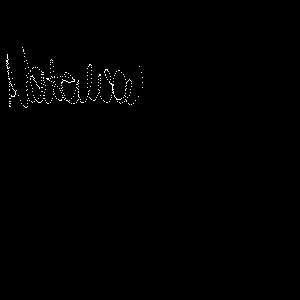

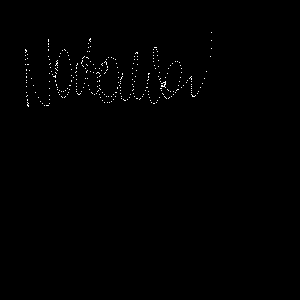

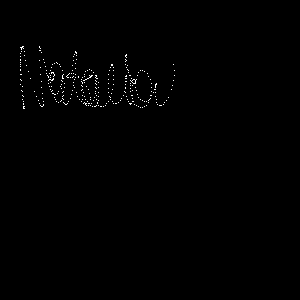

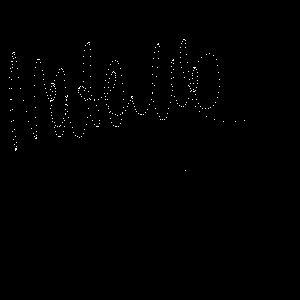

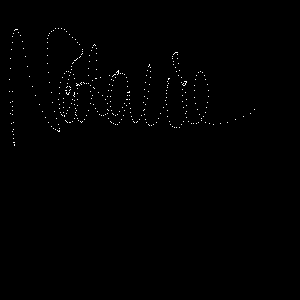

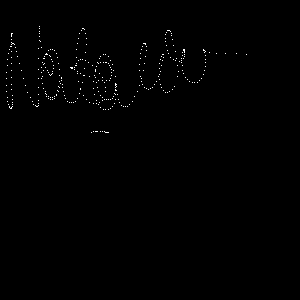

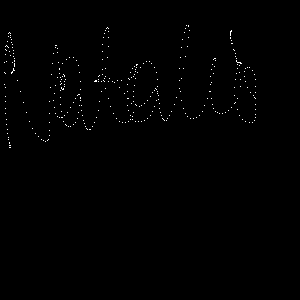

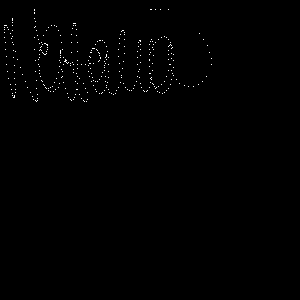

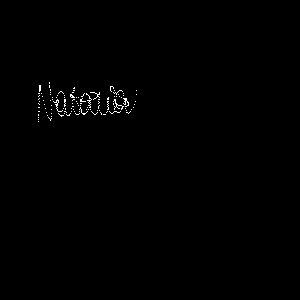

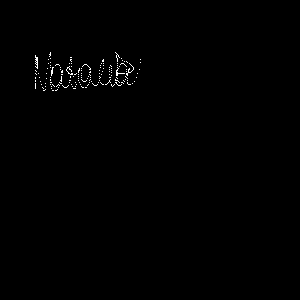

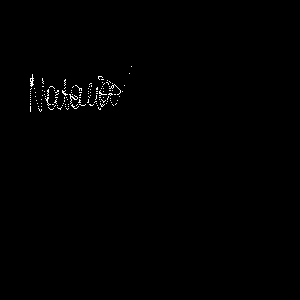

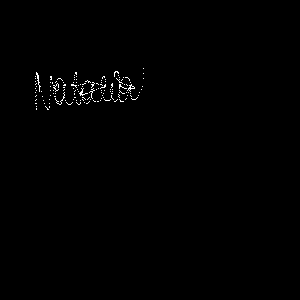

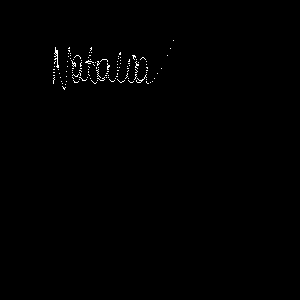

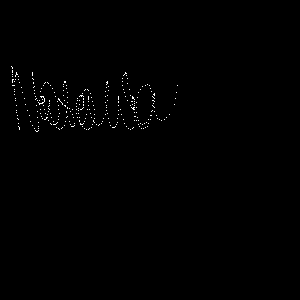

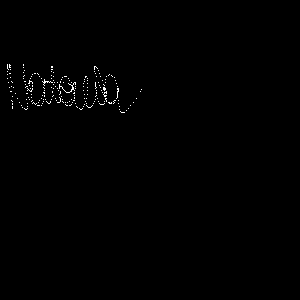

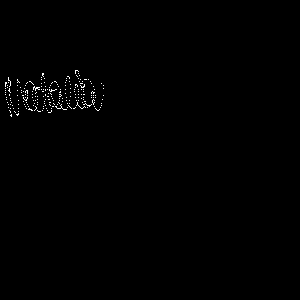

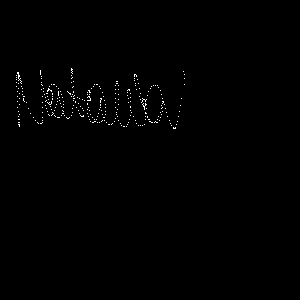

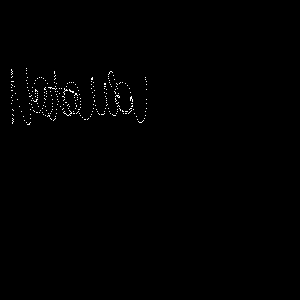

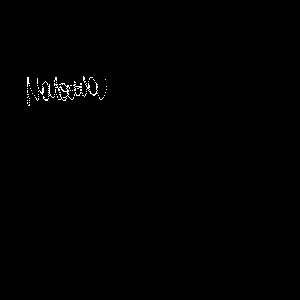

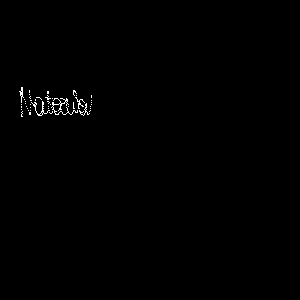

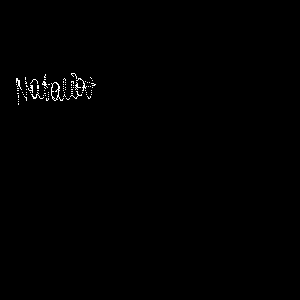

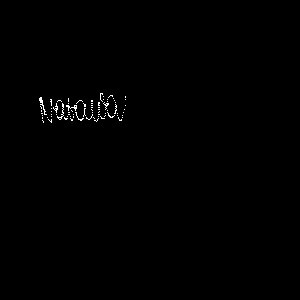

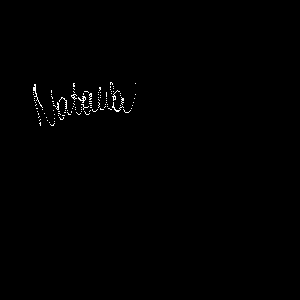

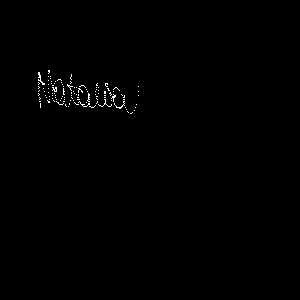

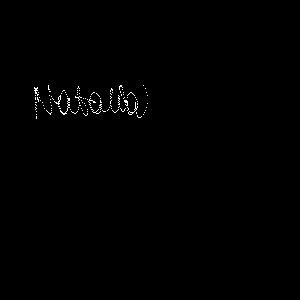

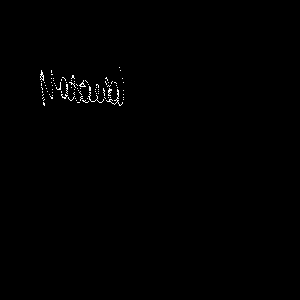

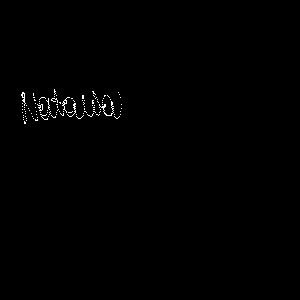

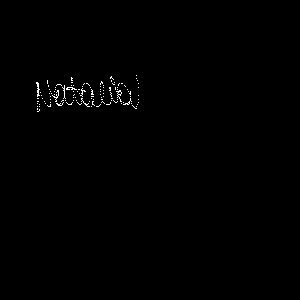

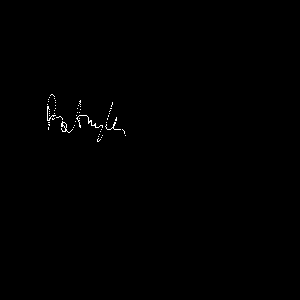

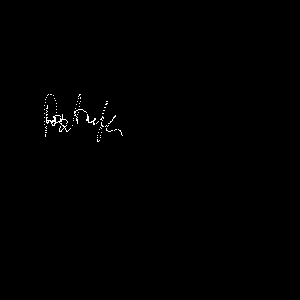

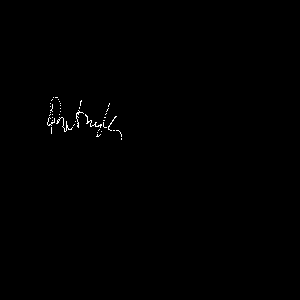

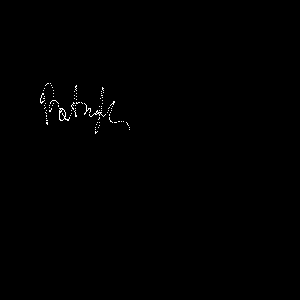

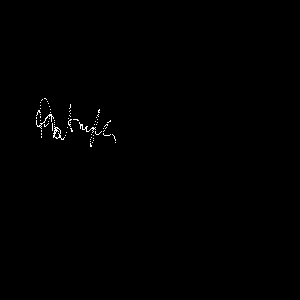

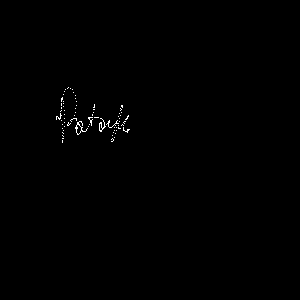

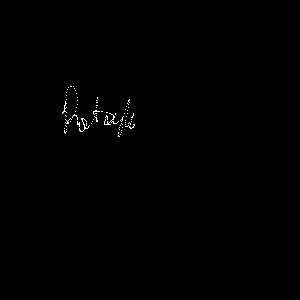

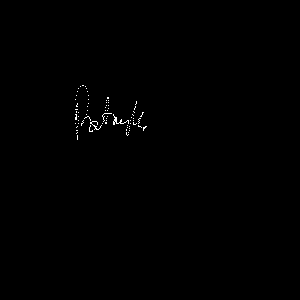

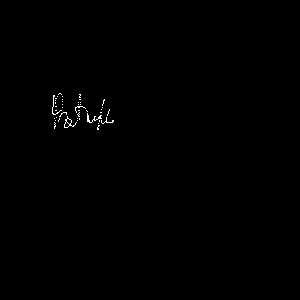

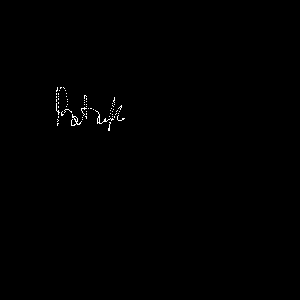

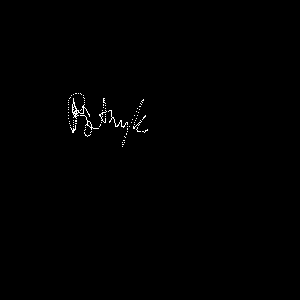

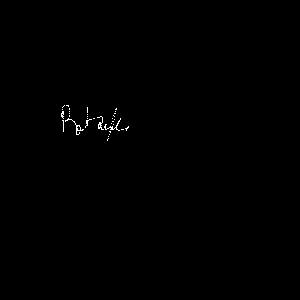

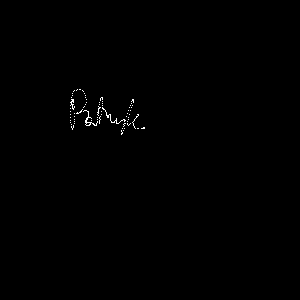

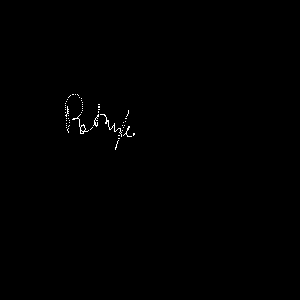

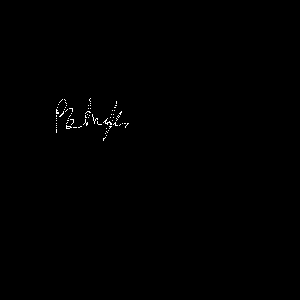

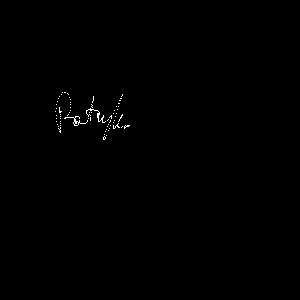

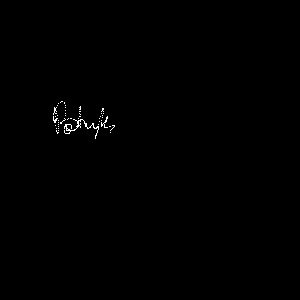

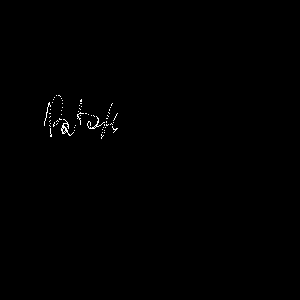

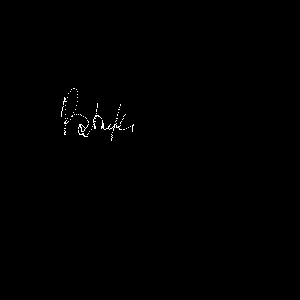

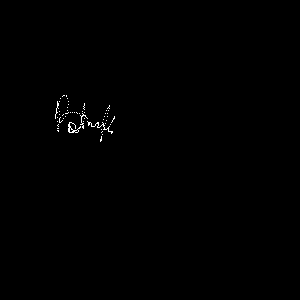

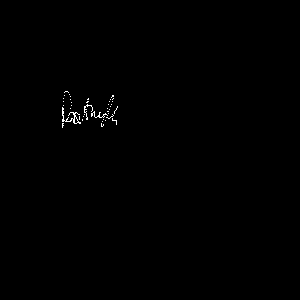

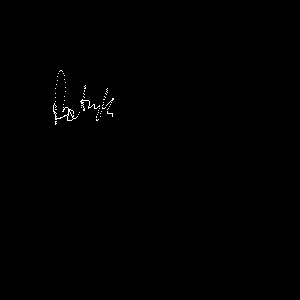

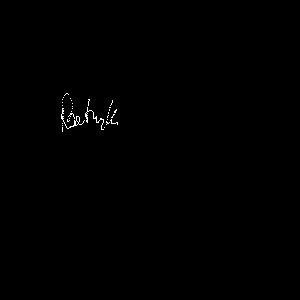

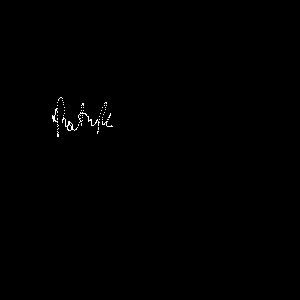

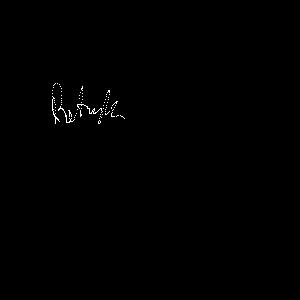

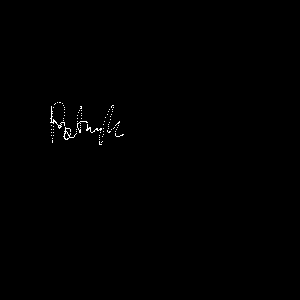

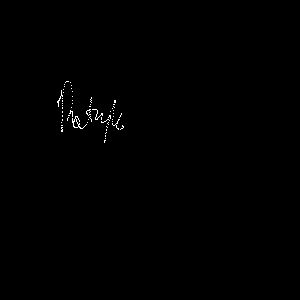

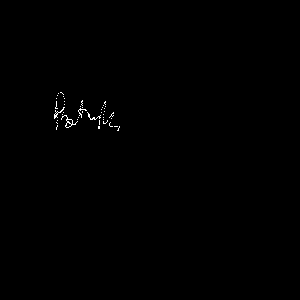

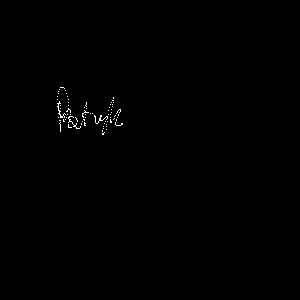

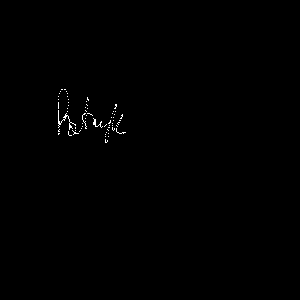

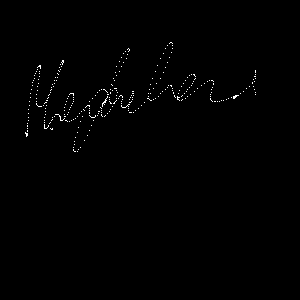

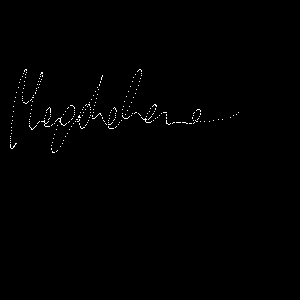

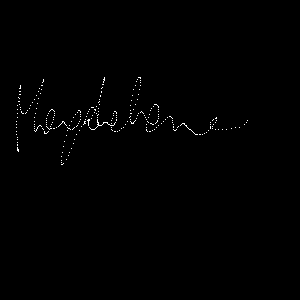

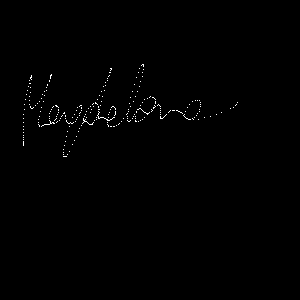

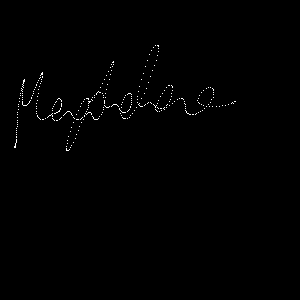

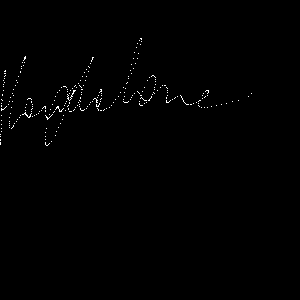

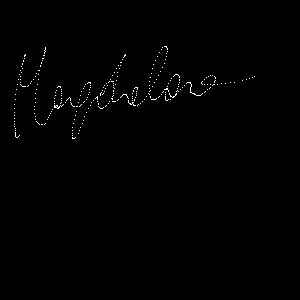

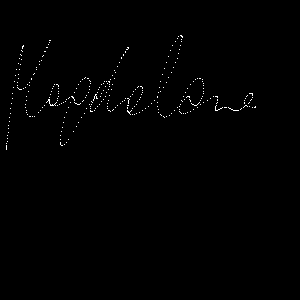

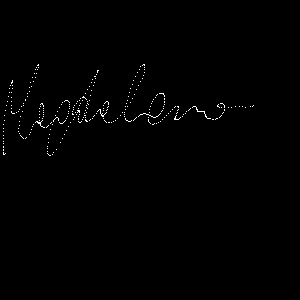

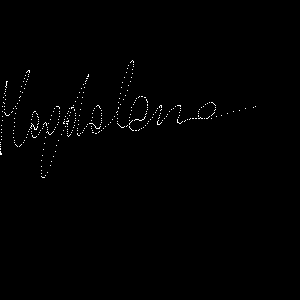

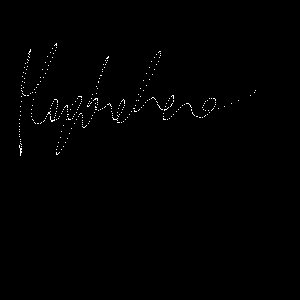

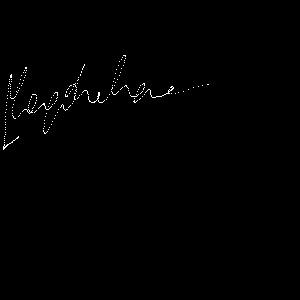

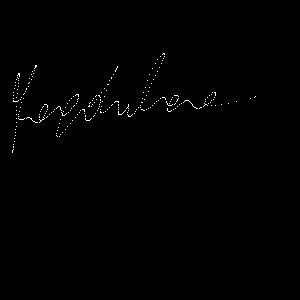

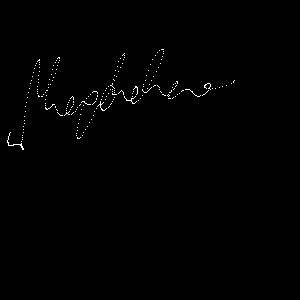

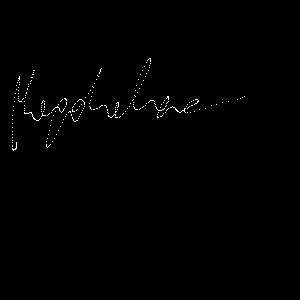

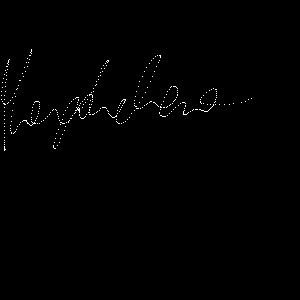

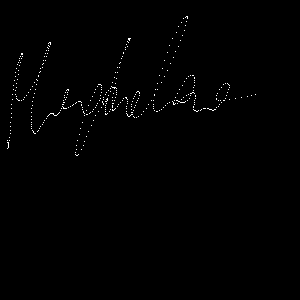

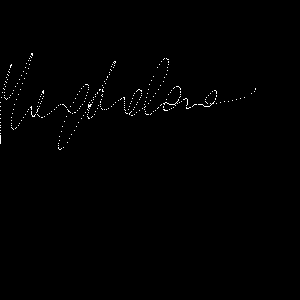

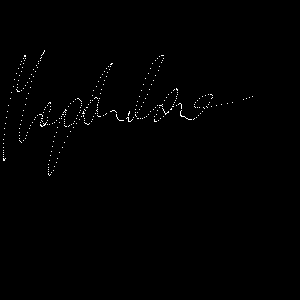

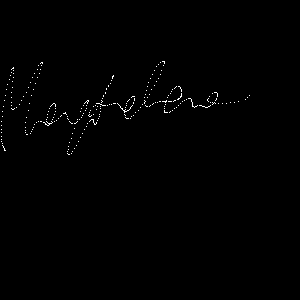

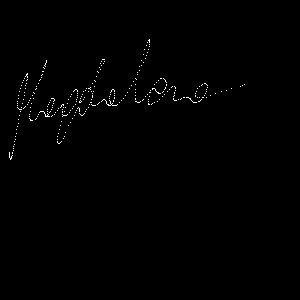

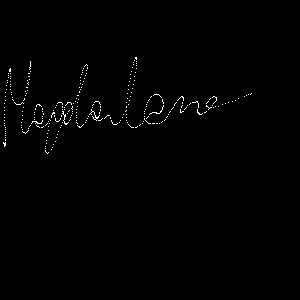

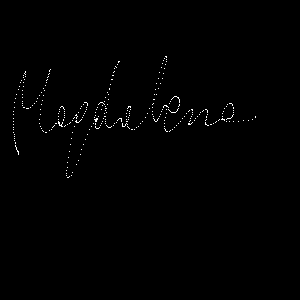

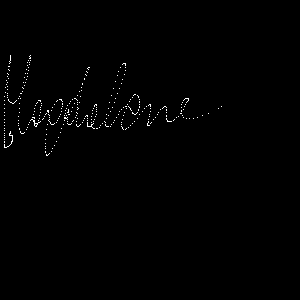

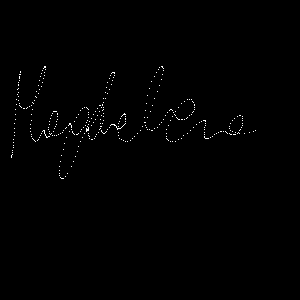

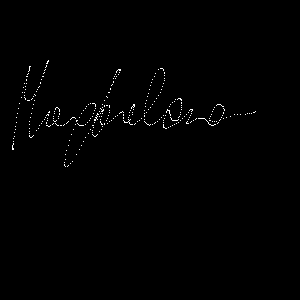

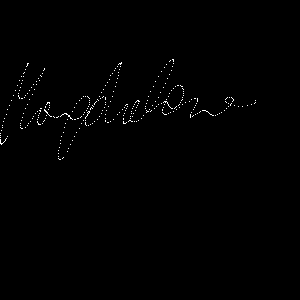

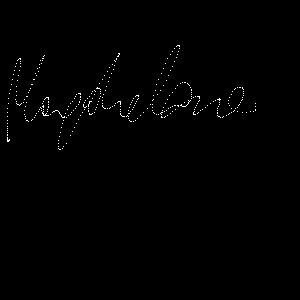

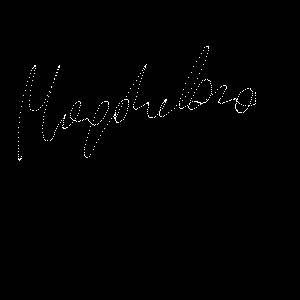

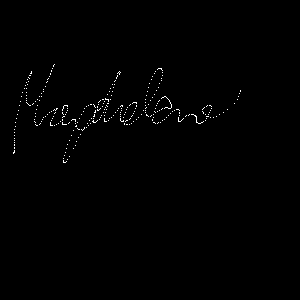

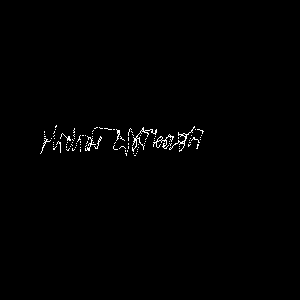

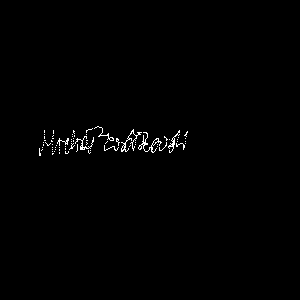

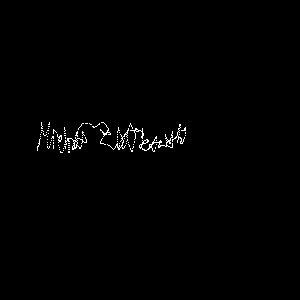

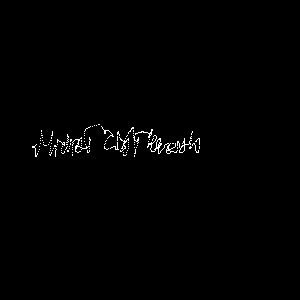

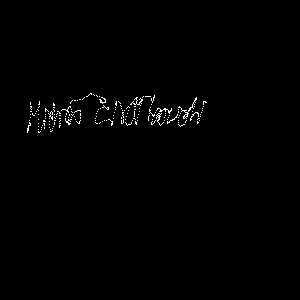

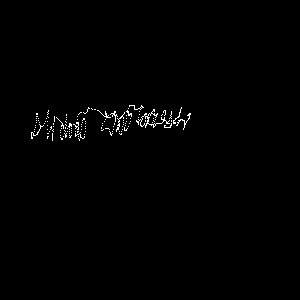

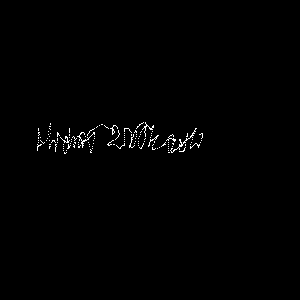

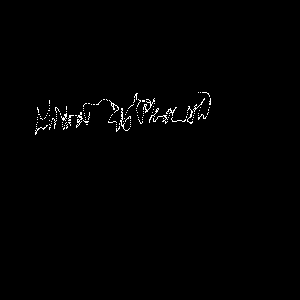

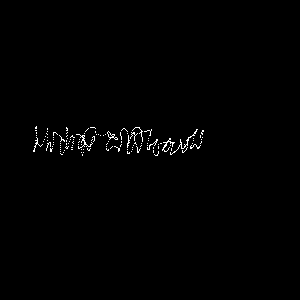

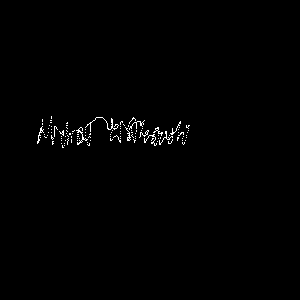

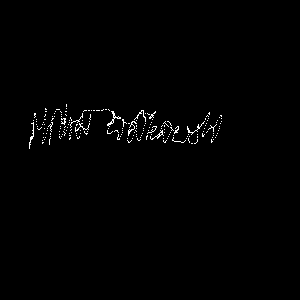

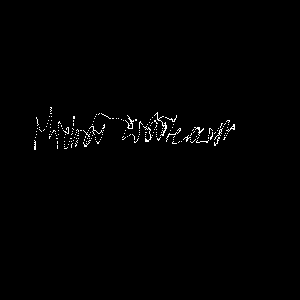

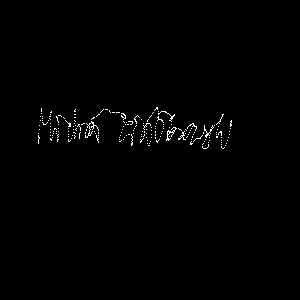

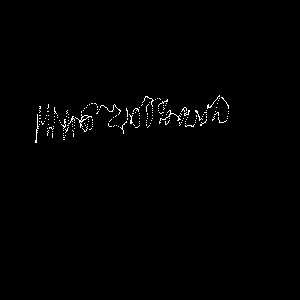

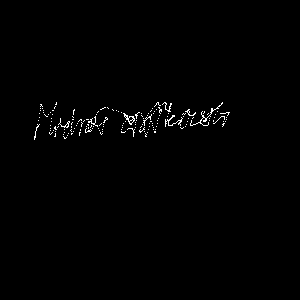

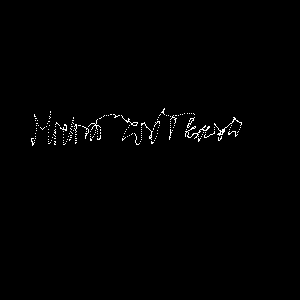

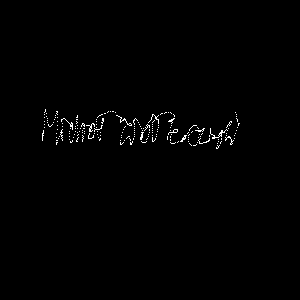

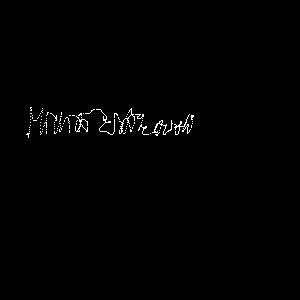

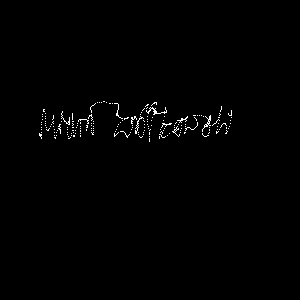

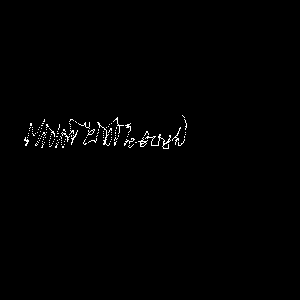

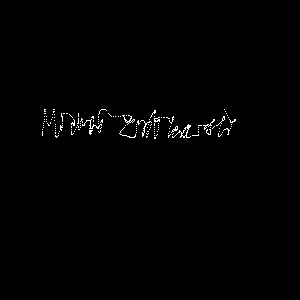

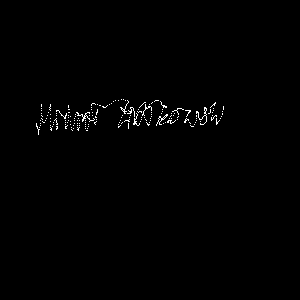

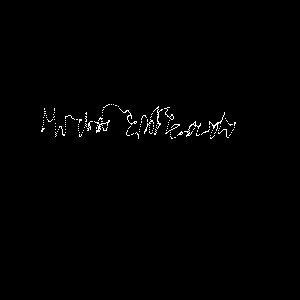

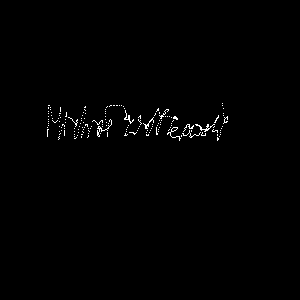

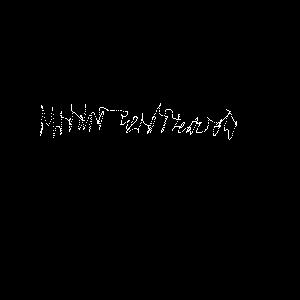

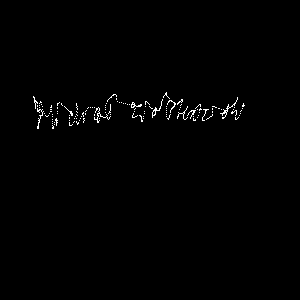

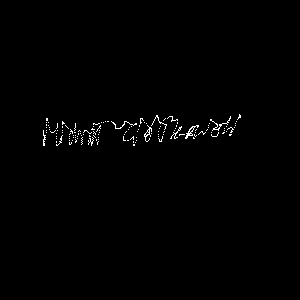

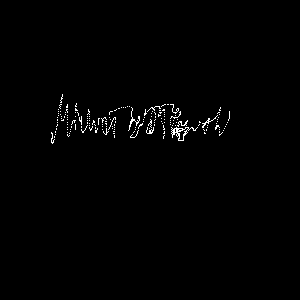

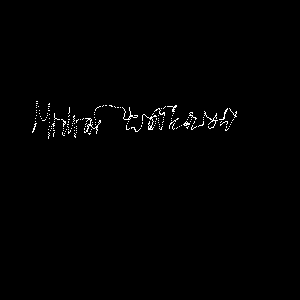

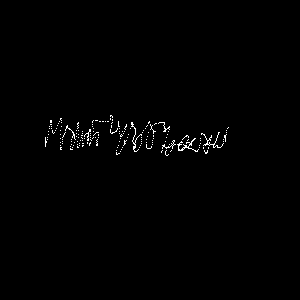

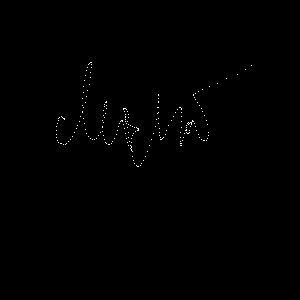

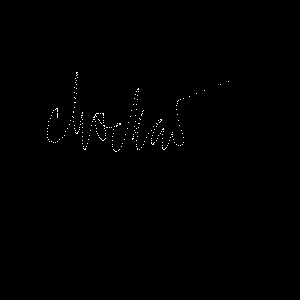

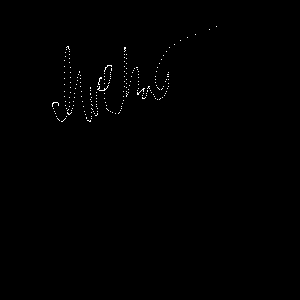

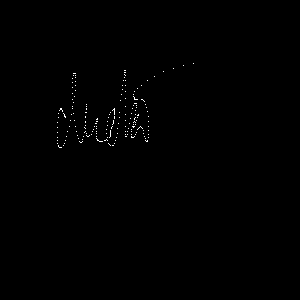

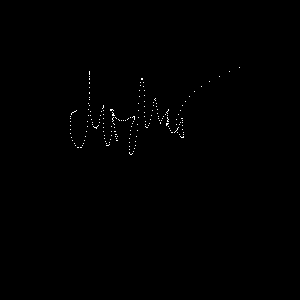

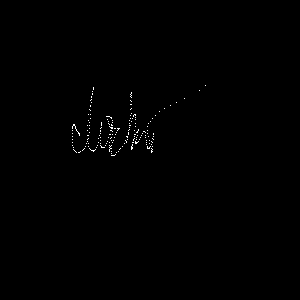

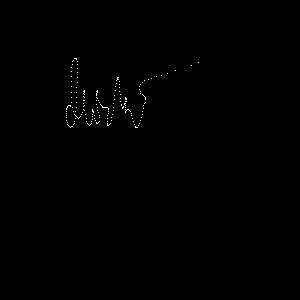

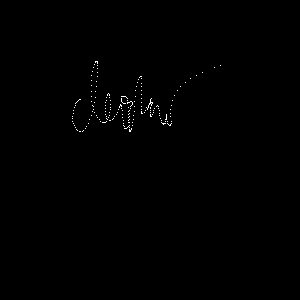

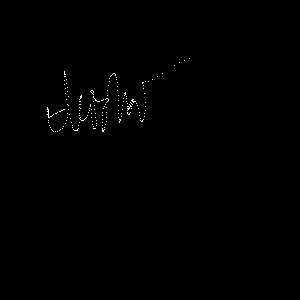

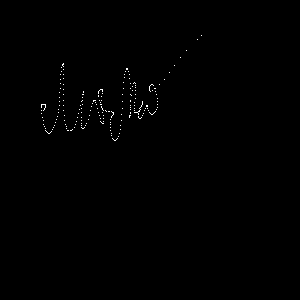

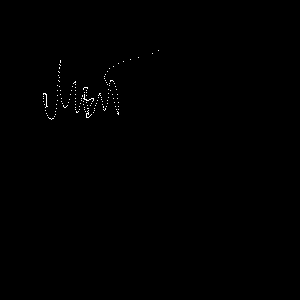

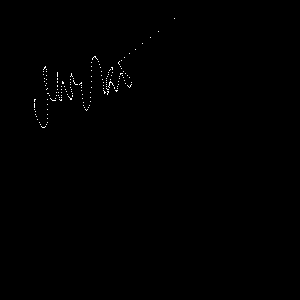

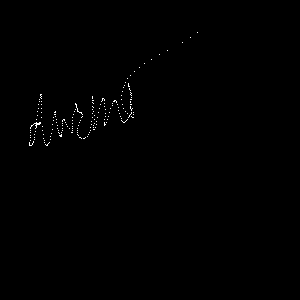

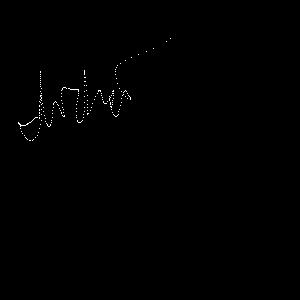

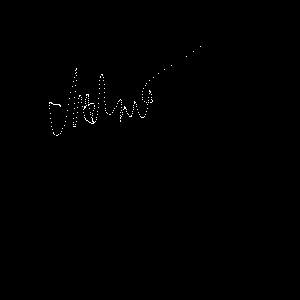

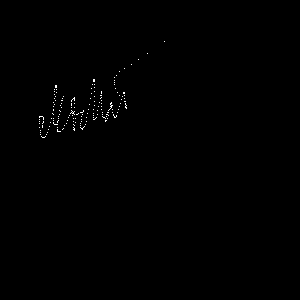

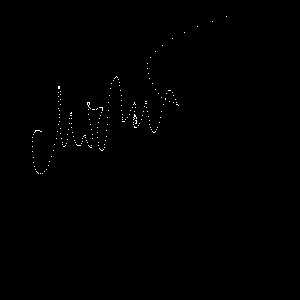

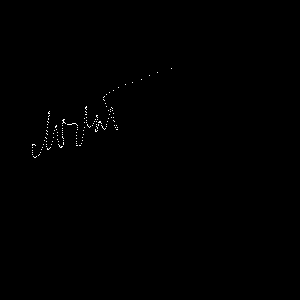

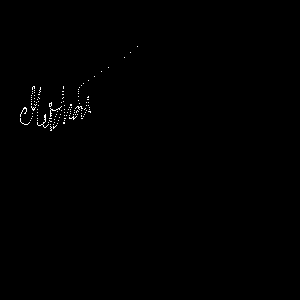

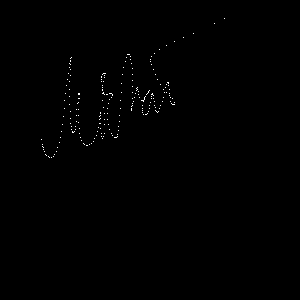

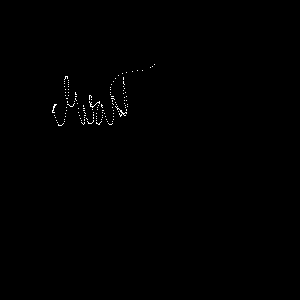

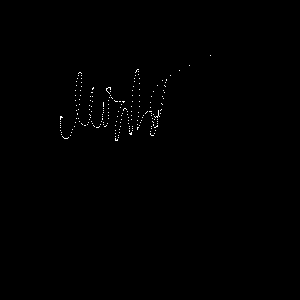

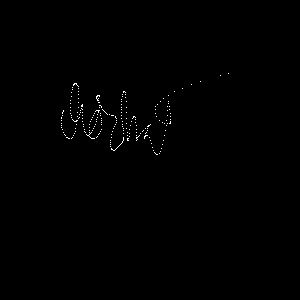

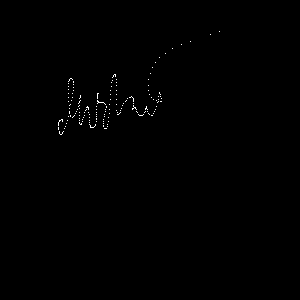

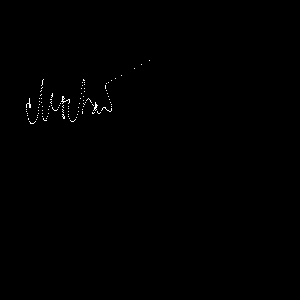

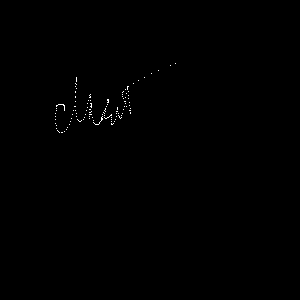

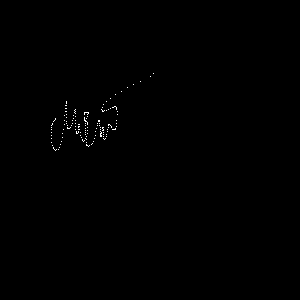

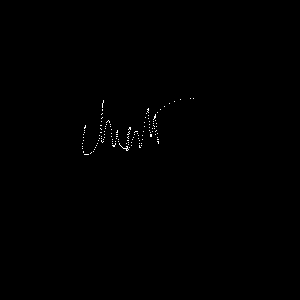

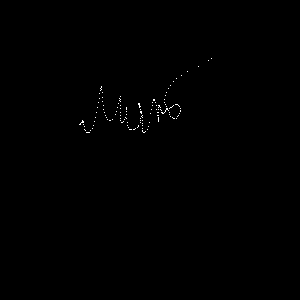

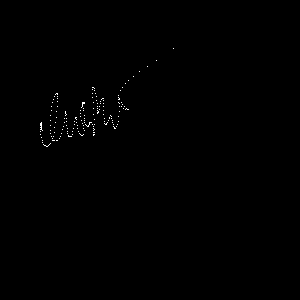

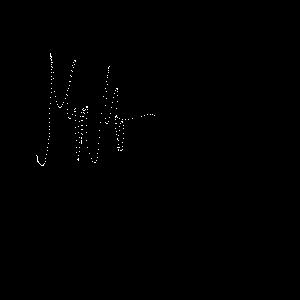

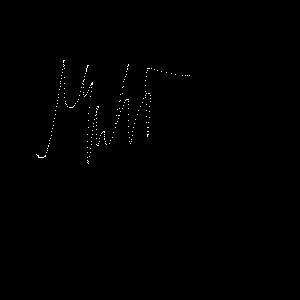

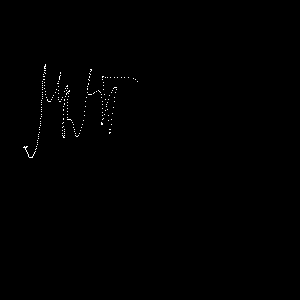

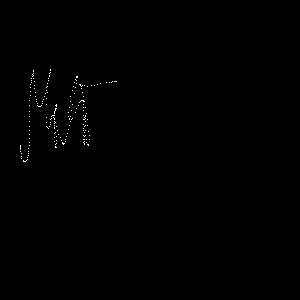

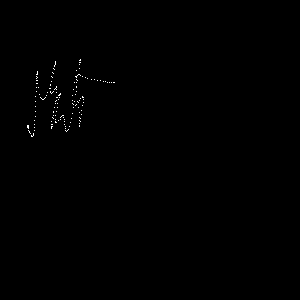

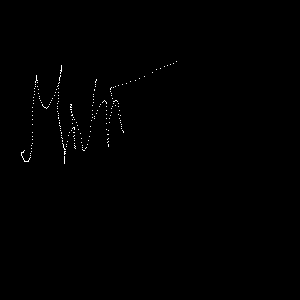

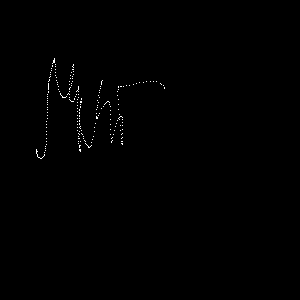

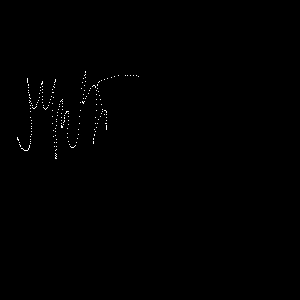

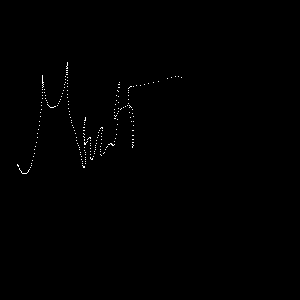

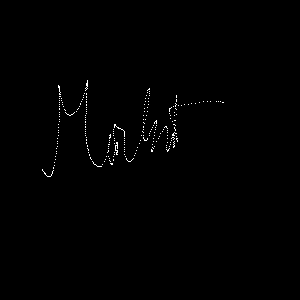

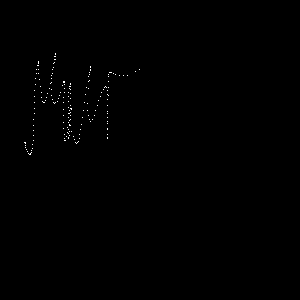

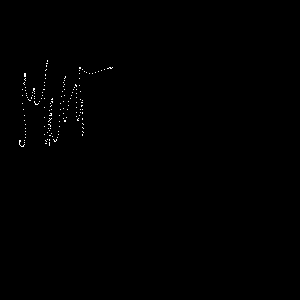

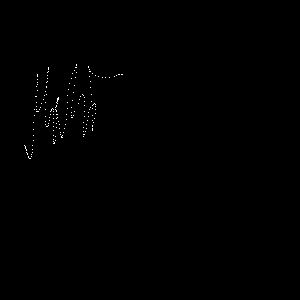

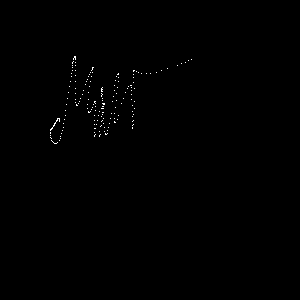

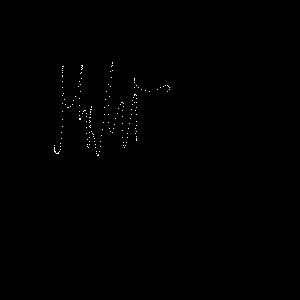

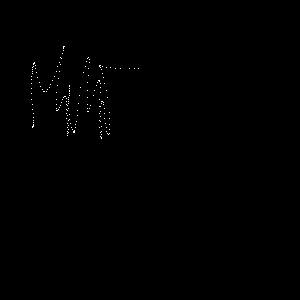

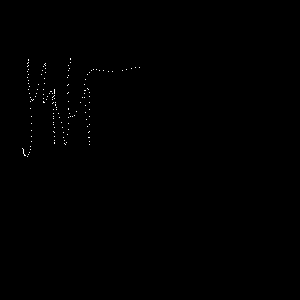

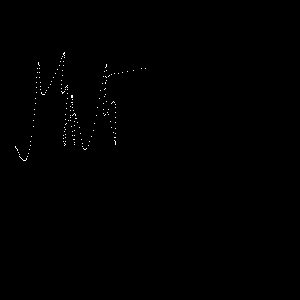

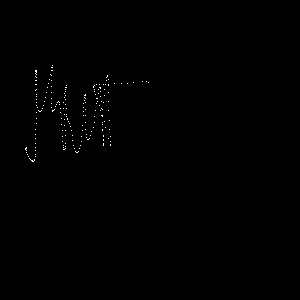

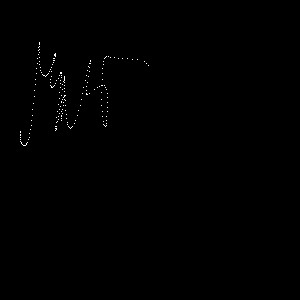

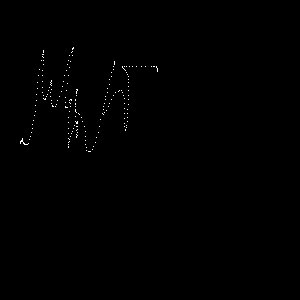

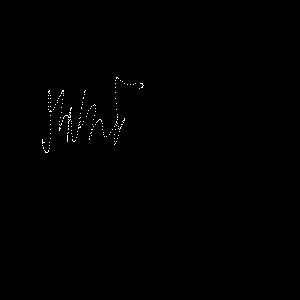

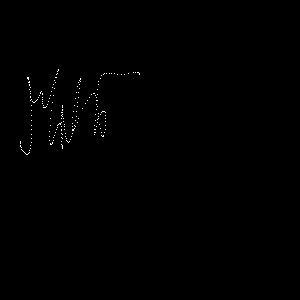

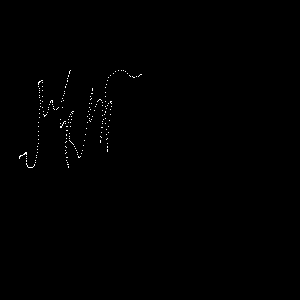

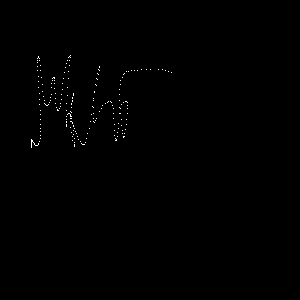

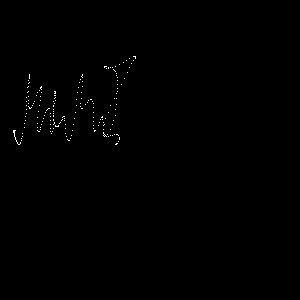

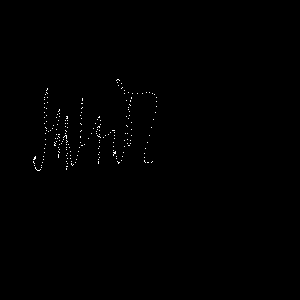

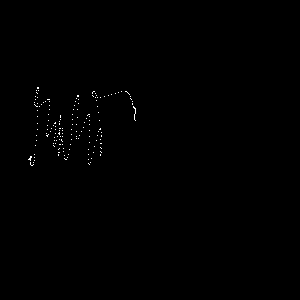

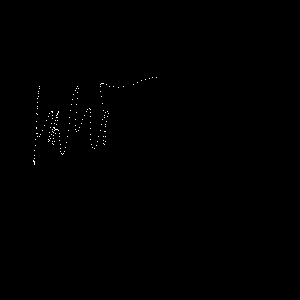

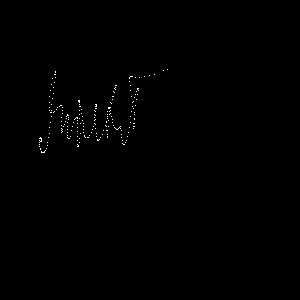

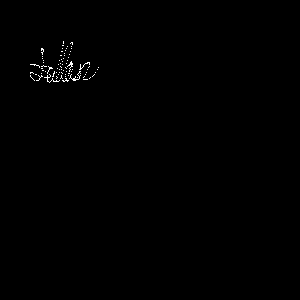

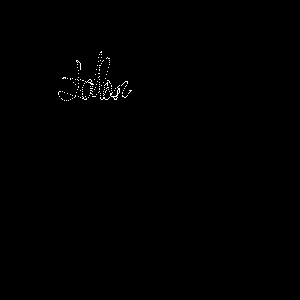

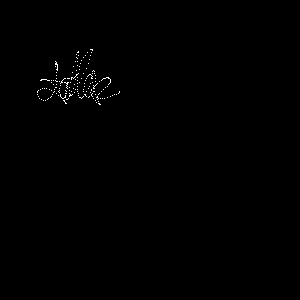

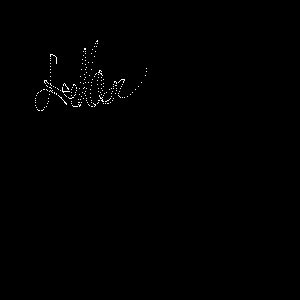

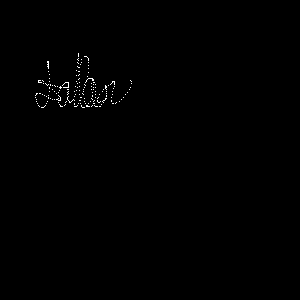

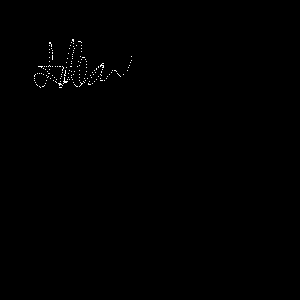

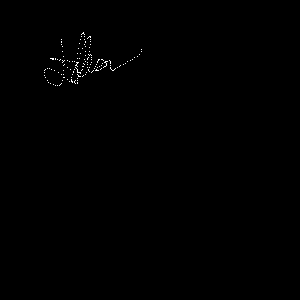

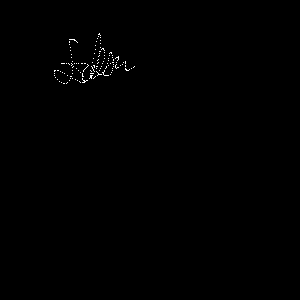

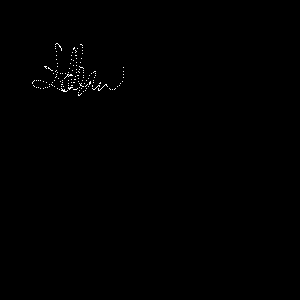

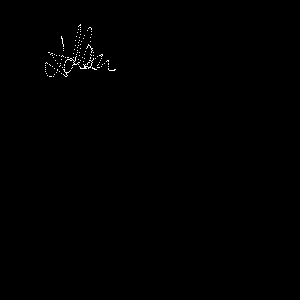

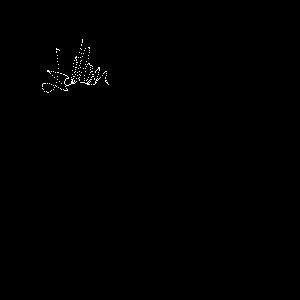

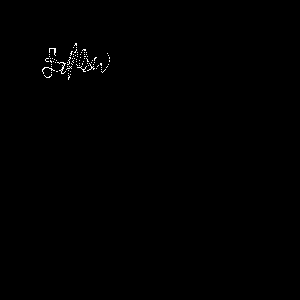

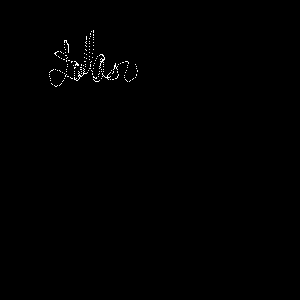

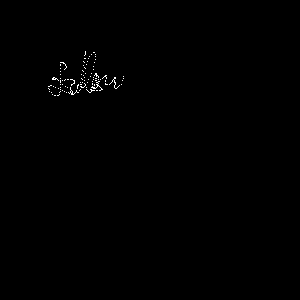

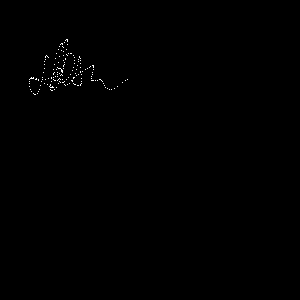

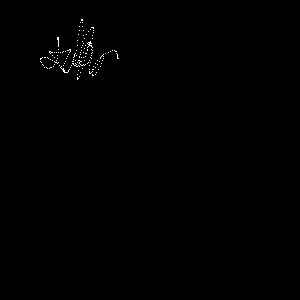

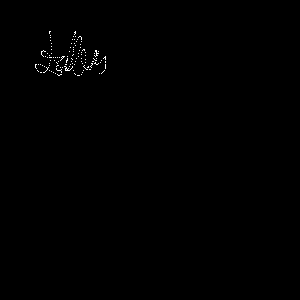

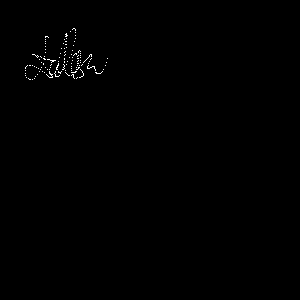

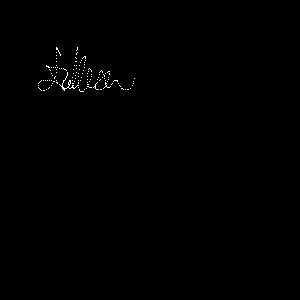

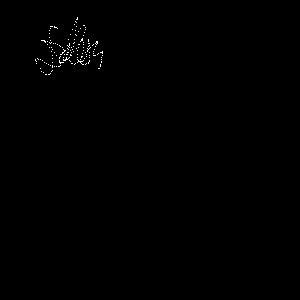

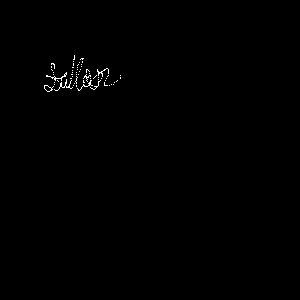

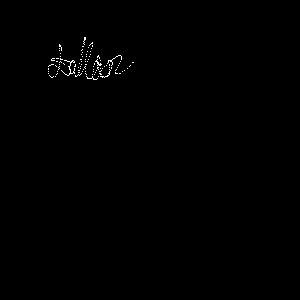

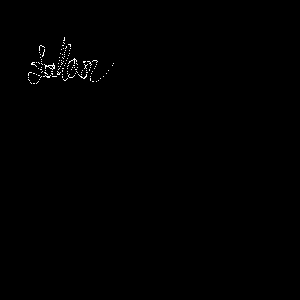

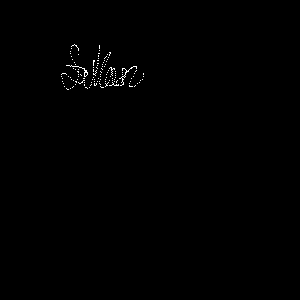

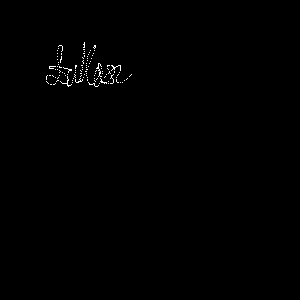

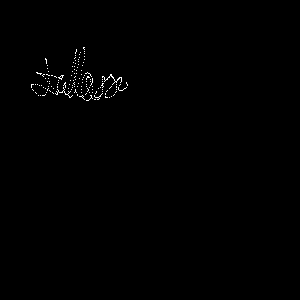

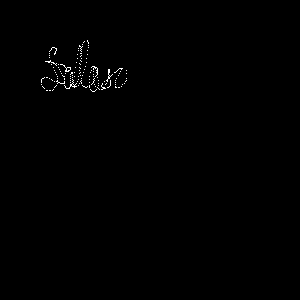

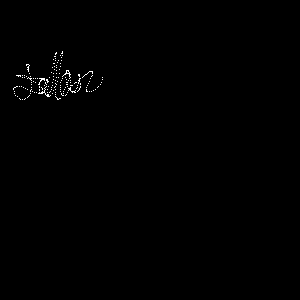

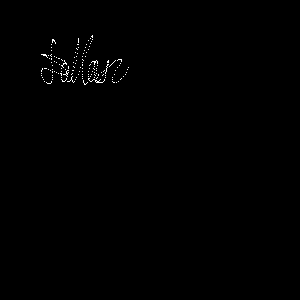

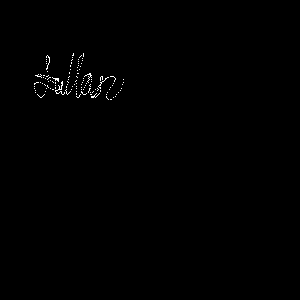

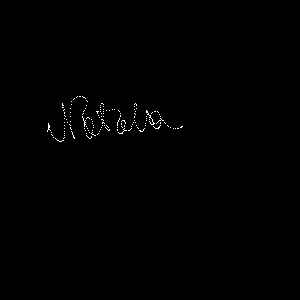

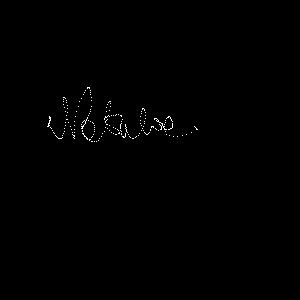

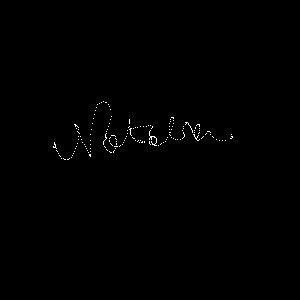

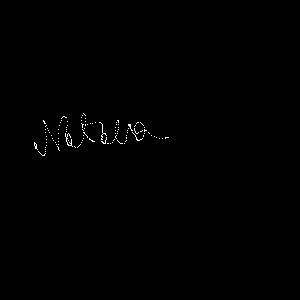

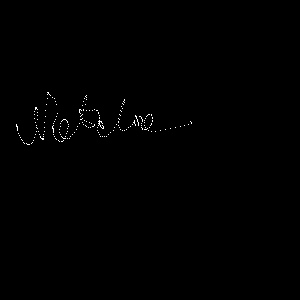

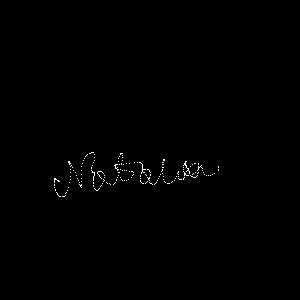

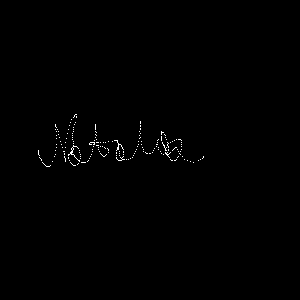

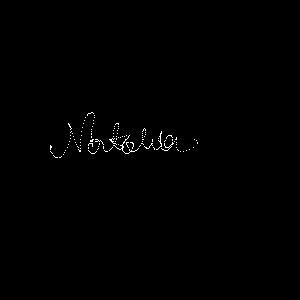

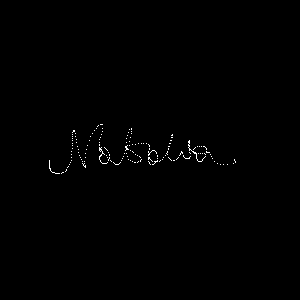

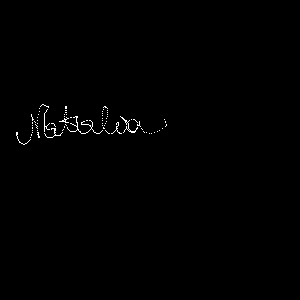

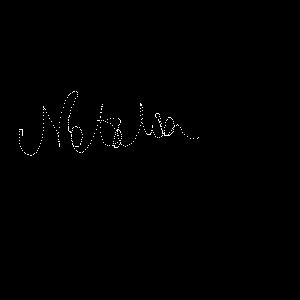

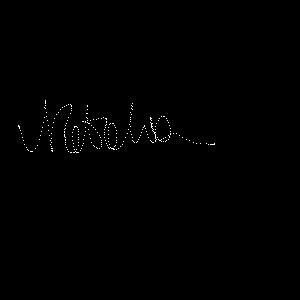

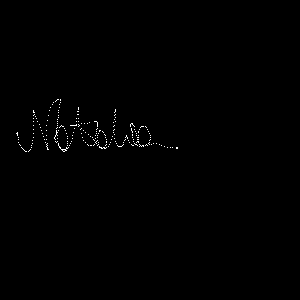

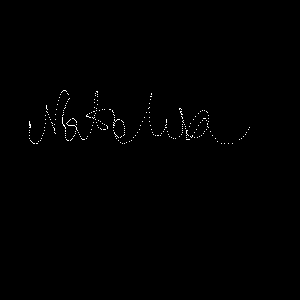

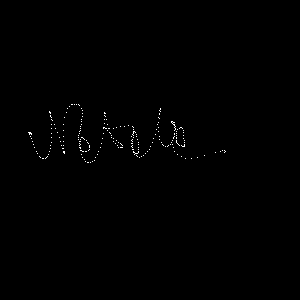

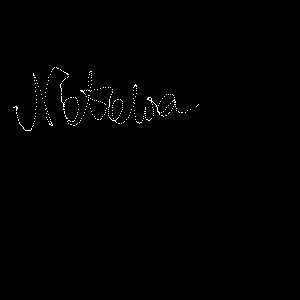

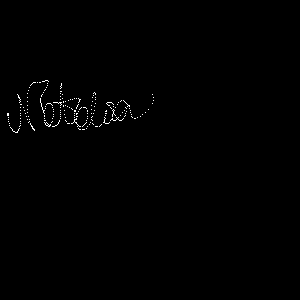

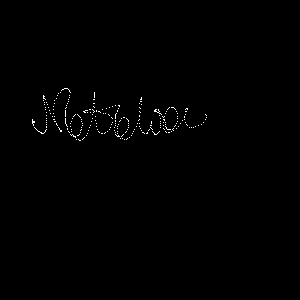

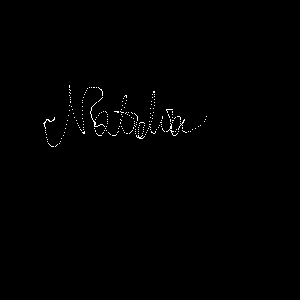

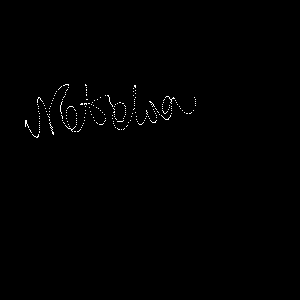

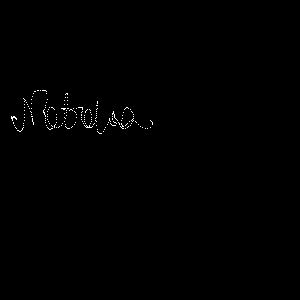

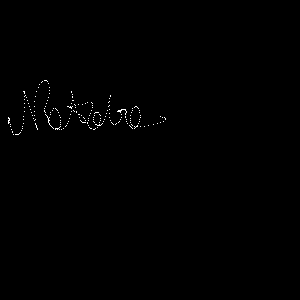

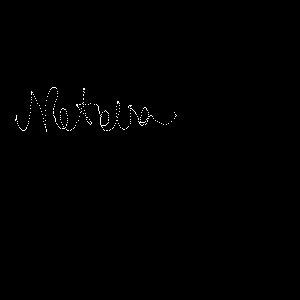

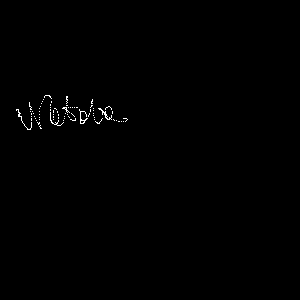

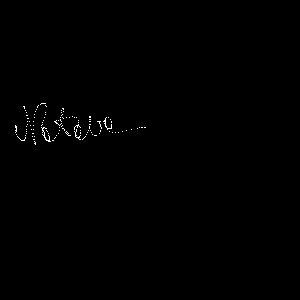

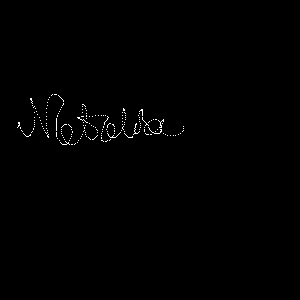

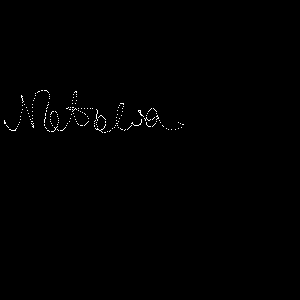

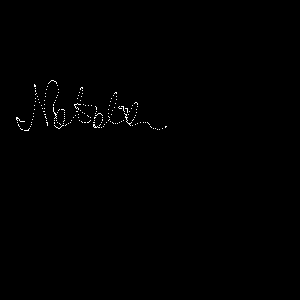

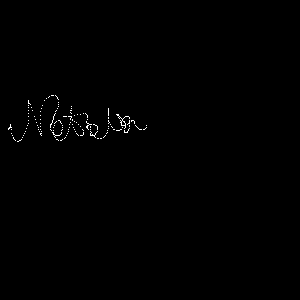

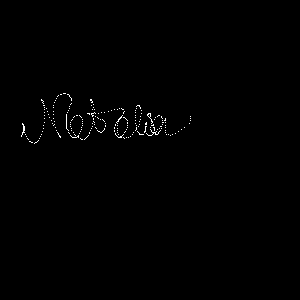

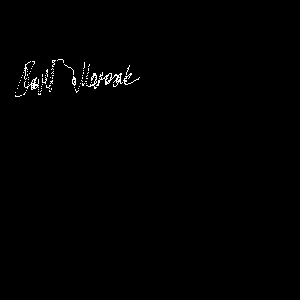

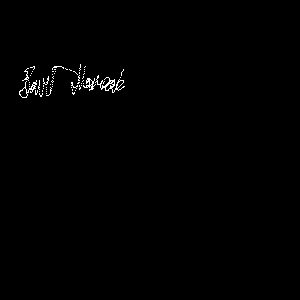

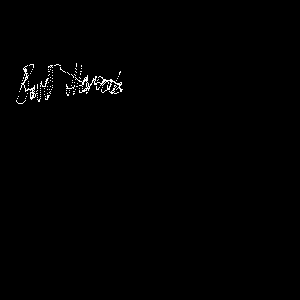

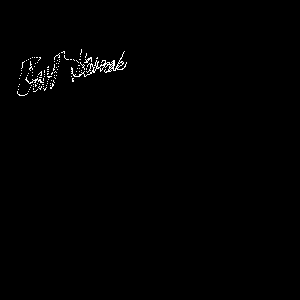

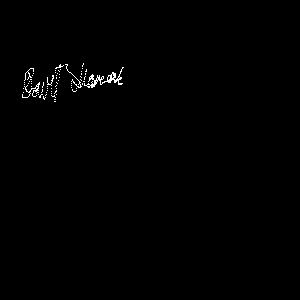

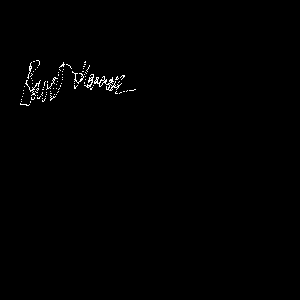

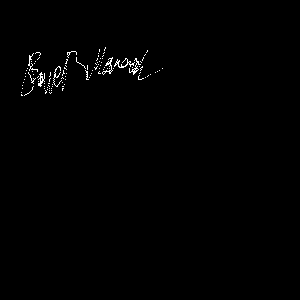

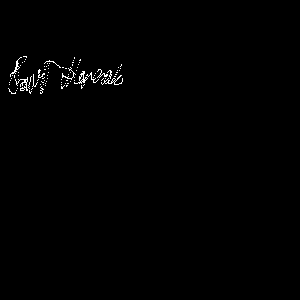

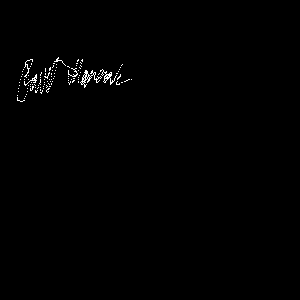

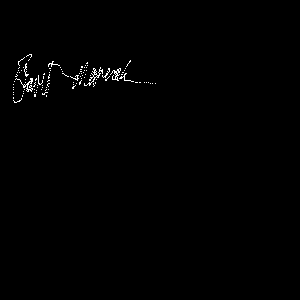

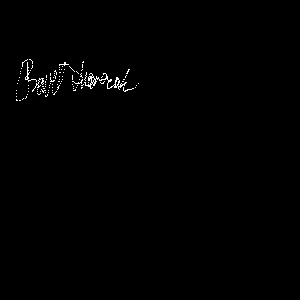

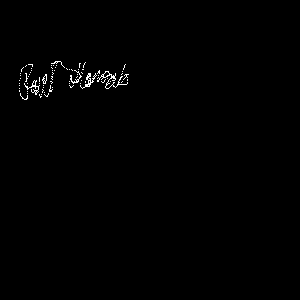

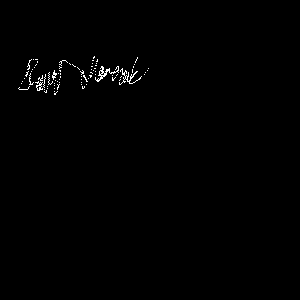

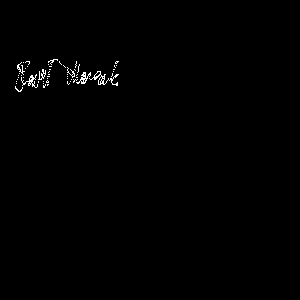

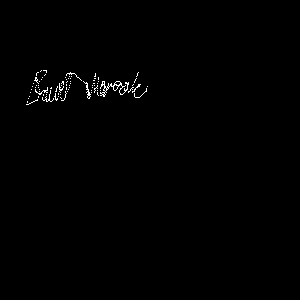

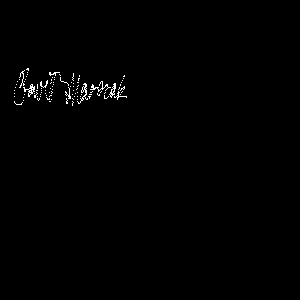

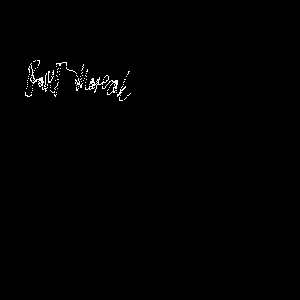

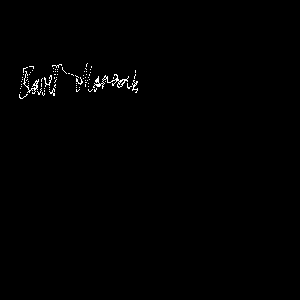

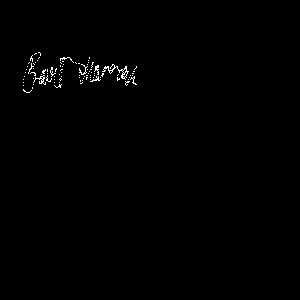

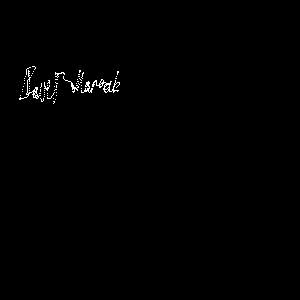

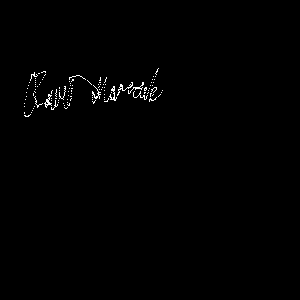

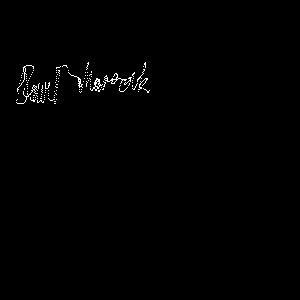

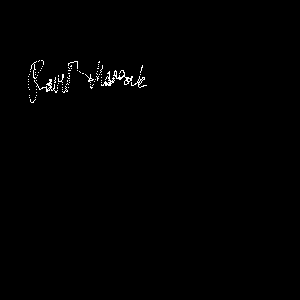

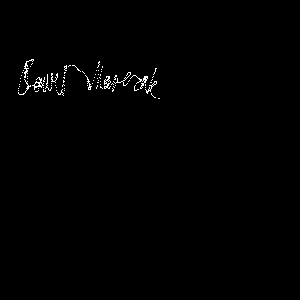

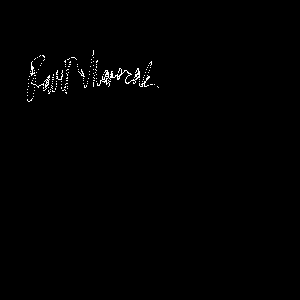

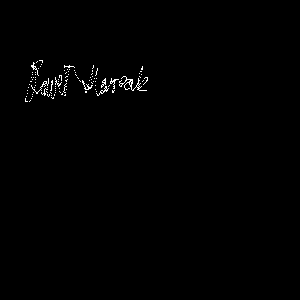

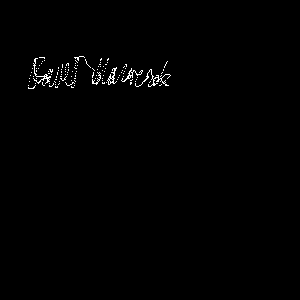

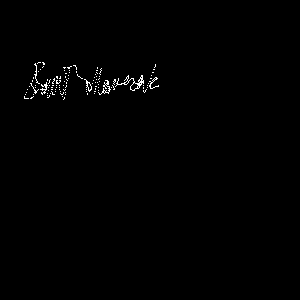

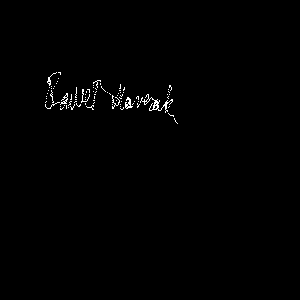

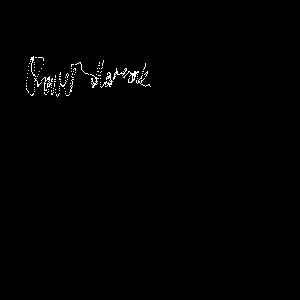

In [7]:
df = pd.DataFrame(columns=['XX','level', 'owner', 'acc_by_dur', 'mean_str_dur','std_str_dur', 'mean_str_len', 'std_str_len', 'min_acc','max_acc','mean_acc','zrc_acc','mean_str_press', 'std_str_press','mean_dir_change_vel'])
id_num=0
for user in os.listdir('/content/drive/MyDrive/Alkohol_dane/Dane'):
  for level in os.listdir(f'/content/drive/MyDrive/Alkohol_dane/Dane/{user}'):
    for filename in os.listdir(f'/content/drive/MyDrive/Alkohol_dane/Dane/{user}/{level}'):
      signature=read_signature(f'/content/drive/MyDrive/Alkohol_dane/Dane/{user}/{level}/{filename}')
      # print(img.shape)
      stats = get_stats(signature)
      row=[id_num,'L'+str(level),user]+stats
      s2 = pd.Series(pd.Series(row,name=id_num, index=['XX','level', 'owner', 'acc_by_dur', 'mean_str_dur','std_str_dur', 'mean_str_len', 'std_str_len', 'min_acc','max_acc','mean_acc','zrc_acc','mean_str_press', 'std_str_press','mean_dir_change_vel']))
      df = df.append(s2, ignore_index=False)
      id_num+=1

In [8]:
df

,XX,level,owner,acc_by_dur,mean_str_dur,std_str_dur,mean_str_len,std_str_len,min_acc,max_acc,mean_acc,zrc_acc,mean_str_press,std_str_press,mean_dir_change_vel
0,0,L4,Natka,0.432488,0.415000,0.317843,180.320240,135.902605,-70312.500000,207050.983066,3358.667043,86,585.737978,112.616332,29.697667
1,1,L4,Natka,0.481938,0.384000,0.314103,160.513829,135.078928,-51171.748091,81858.378329,1536.560239,86,589.315932,92.861890,32.019767
2,2,L4,Natka,0.460547,0.484500,0.356255,164.664455,115.293748,-30596.369823,84294.946825,1800.412073,122,649.651359,76.108875,30.598403
3,3,L4,Natka,0.460486,0.393857,0.304580,164.376146,136.367438,-55782.312925,79956.676502,2275.156331,96,558.625072,86.573288,32.956305
4,4,L4,Natka,0.455124,0.178750,0.180146,69.920054,69.772506,-63481.830903,160558.608036,2274.095219,86,571.694538,113.505208,30.316241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,265,L0,Pawel,0.411765,0.272800,0.260273,46.931981,45.889248,-22881.273056,26690.718086,491.991847,151,696.555961,81.576547,31.991886
266,266,L0,Pawel,0.408665,0.132115,0.124953,21.105097,18.425399,-21614.583333,28656.400073,567.799717,172,649.196103,213.758048,31.493602
267,267,L0,Pawel,0.427708,0.062065,0.060678,11.090570,10.258034,-26696.018572,30577.777778,556.646091,163,646.957793,167.679769,32.361095
268,268,L0,Pawel,0.410153,0.152448,0.240040,22.947882,34.991719,-22006.566437,24957.264957,719.636786,164,627.095983,221.749669,30.870444


In [9]:
df.to_csv('/content/drive/MyDrive/Alkohol_dane/Alkohol_dane.csv',index=False)

# Read CSV and explore data

In [1]:
pip install scipy -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install scikit_posthocs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os, shutil
import time, datetime, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from IPython.display import display, HTML
import scikit_posthocs as sp

data_fname = 'Alkohol_dane.csv'
data_dir = '/content/drive/MyDrive/Alkohol_dane/'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
db_raw = pd.read_csv(os.path.join(data_dir, data_fname))

# Convert the first variable to category type
db_raw['XX'] = db_raw['XX'].astype('category')
# db_raw['category'] = db_raw['category'].astype('category')

n_all_features = db_raw.shape[1] - 3

print('Raw data shape:', db_raw.shape)

Raw data shape: (270, 15)


In [6]:
db_raw

,XX,level,owner,acc_by_dur,mean_str_dur,std_str_dur,mean_str_len,std_str_len,min_acc,max_acc,mean_acc,zrc_acc,mean_str_press,std_str_press,mean_dir_change_vel
0,0,L4,Natka,0.432488,0.415000,0.317843,180.320240,135.902605,-70312.500000,207050.983066,3358.667043,86,585.737978,112.616332,29.697667
1,1,L4,Natka,0.481938,0.384000,0.314103,160.513829,135.078928,-51171.748091,81858.378329,1536.560239,86,589.315932,92.861890,32.019767
2,2,L4,Natka,0.460547,0.484500,0.356255,164.664455,115.293748,-30596.369823,84294.946825,1800.412073,122,649.651359,76.108875,30.598403
3,3,L4,Natka,0.460486,0.393857,0.304580,164.376146,136.367438,-55782.312925,79956.676502,2275.156331,96,558.625072,86.573288,32.956305
4,4,L4,Natka,0.455124,0.178750,0.180146,69.920054,69.772506,-63481.830903,160558.608036,2274.095219,86,571.694538,113.505208,30.316241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,265,L0,Pawel,0.411765,0.272800,0.260273,46.931981,45.889248,-22881.273056,26690.718086,491.991847,151,696.555961,81.576547,31.991886
266,266,L0,Pawel,0.408665,0.132115,0.124953,21.105097,18.425399,-21614.583333,28656.400073,567.799717,172,649.196103,213.758048,31.493602
267,267,L0,Pawel,0.427708,0.062065,0.060678,11.090570,10.258034,-26696.018572,30577.777778,556.646091,163,646.957793,167.679769,32.361095
268,268,L0,Pawel,0.410153,0.152448,0.240040,22.947882,34.991719,-22006.566437,24957.264957,719.636786,164,627.095983,221.749669,30.870444


In [7]:
db_raw.iloc[:,:3].describe(include = 'all').T

,count,unique,top,freq
XX,270,270,0,1
level,270,6,L4,45
owner,270,9,Natka,30


In [8]:
db_raw.iloc[:,3:].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
acc_by_dur,270.0,0.472687,0.146058,0.150617,0.410916,0.447148,0.475207,1.107015
mean_str_dur,270.0,0.090661,1.913591,-19.233667,0.245848,0.352692,0.440208,3.574000
std_str_dur,270.0,1.166588,4.047741,0.000000,0.172429,0.243027,0.317582,27.945347
mean_str_len,270.0,115.043080,119.024857,11.090570,59.732655,80.529313,124.489958,985.312301
std_str_len,270.0,74.593535,52.612974,0.000000,40.204193,59.339869,91.066383,322.276503
min_acc,270.0,-33604.219154,13972.098755,-109711.768731,-38376.773165,-30503.279229,-24150.847016,-11084.852890
max_acc,270.0,53730.637006,36902.662082,17777.777778,30702.789511,45879.737332,62500.000000,301469.808417
mean_acc,270.0,1049.852970,699.948119,131.248466,449.892557,1010.930553,1457.426129,4246.399087
zrc_acc,270.0,103.455556,48.396249,36.000000,67.000000,89.000000,126.500000,233.000000
mean_str_press,270.0,678.213664,155.886496,327.221472,565.425072,653.917104,801.259566,987.583829


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/boxplot.py:405: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


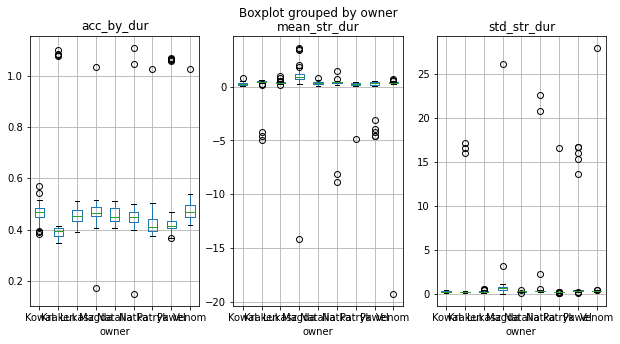

In [9]:
fig, ax_new = plt.subplots(1,3,figsize=[10,5], sharey=False)
db_raw.boxplot(column=['acc_by_dur', 'mean_str_dur','std_str_dur'], by='owner',ax=ax_new,figsize=[10,5])
plt.show()

# Filter polluted records

In [10]:
filt_db_raw=db_raw[ db_raw['mean_str_dur'] >=0]
filt_db_raw=filt_db_raw[ (filt_db_raw['acc_by_dur'] <1) & (filt_db_raw['acc_by_dur'] >0.2)]

In [11]:
filt_db_raw['owner'].value_counts()

Kowal      30
Lukasz     30
Natalia    30
Patryk     29
Venom      29
Magda      28
Natka      27
Kraken     26
Pawel      25
Name: owner, dtype: int64

In [13]:
filt_db_raw['level'].value_counts()

L1    45
L4    42
L0    42
L3    42
L2    42
L5    41
Name: level, dtype: int64

In [14]:
filt_db_raw.shape

(254, 15)

In [15]:
grouped = filt_db_raw.groupby(["owner",'level'])

In [16]:
df_counts=grouped.count()['XX']

In [17]:
df_counts.groupby('owner').agg(max)

owner
Kowal      5
Kraken     5
Lukasz     5
Magda      5
Natalia    5
Natka      5
Patryk     5
Pawel      5
Venom      5
Name: XX, dtype: int64

In [18]:
df_counts=df_counts.groupby('owner').agg(min)

In [19]:
df_counts

owner
Kowal      5
Kraken     3
Lukasz     5
Magda      3
Natalia    5
Natka      3
Patryk     4
Pawel      3
Venom      4
Name: XX, dtype: int64

# Balancing classes for Friedman test

In [20]:
for name in df_counts.index:
  temp_df=filt_db_raw[filt_db_raw['owner']==name]
  for level in pd.unique(temp_df['level']):
    r_count=temp_df[temp_df['level']==level]['XX'].count()
    ind=temp_df[temp_df['level']==level].tail(r_count-df_counts[name]).index
    filt_db_raw.drop(ind,inplace=True)

In [21]:
filt_db_raw['level'].value_counts()

L4    35
L5    35
L0    35
L3    35
L2    35
L1    35
Name: level, dtype: int64

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/boxplot.py:405: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isi

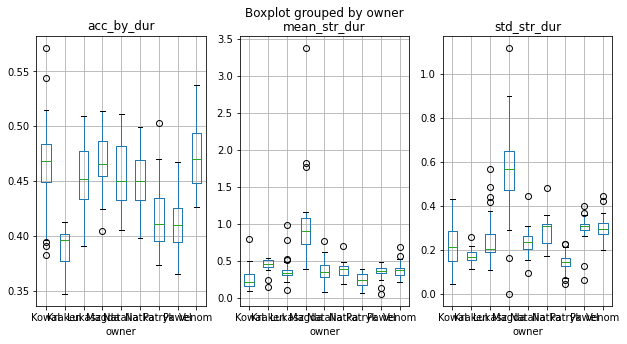

In [22]:
fig, ax_new = plt.subplots(1,3,figsize=[10,5], sharey=False)
filt_db_raw.boxplot(column=['acc_by_dur', 'mean_str_dur','std_str_dur'], by='owner',ax=ax_new,figsize=[10,5])
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/boxplot.py:405: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isi

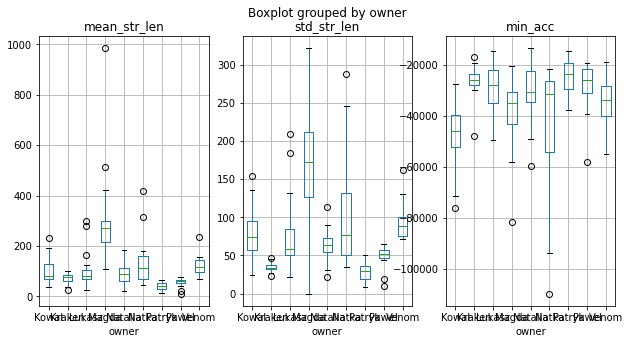

In [27]:
fig, ax_new = plt.subplots(1,3,figsize=[10,5], sharey=False)
filt_db_raw.boxplot(column=['mean_str_len', 'std_str_len','min_acc'], by='owner',ax=ax_new,figsize=[10,5])
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/boxplot.py:405: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isi

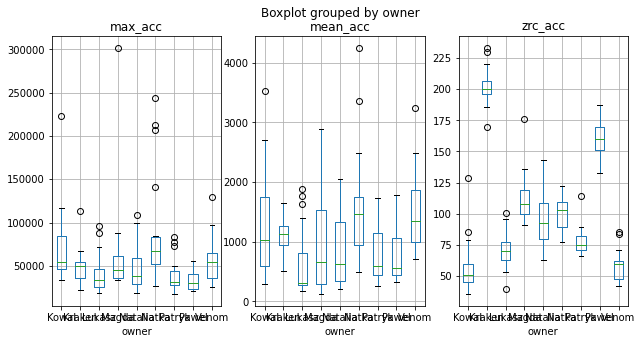

In [28]:
fig, ax_new = plt.subplots(1,3,figsize=[10,5], sharey=False)
filt_db_raw.boxplot(column=['max_acc', 'mean_acc','zrc_acc'], by='owner',ax=ax_new,figsize=[10,5])
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/boxplot.py:405: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isi

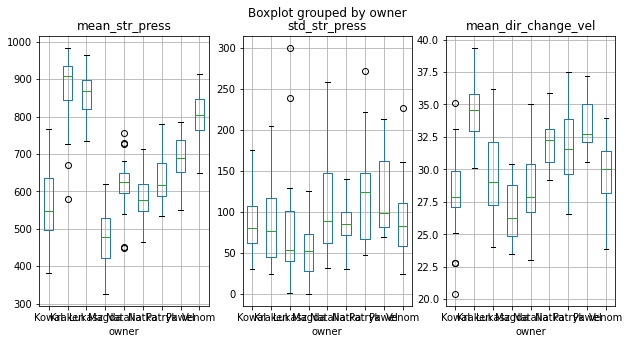

In [29]:
fig, ax_new = plt.subplots(1,3,figsize=[10,5], sharey=False)
filt_db_raw.boxplot(column=['mean_str_press', 'std_str_press','mean_dir_change_vel'], by='owner',ax=ax_new,figsize=[10,5])
plt.show()

# Testing ANOVA assumptions

In [30]:
lev0=filt_db_raw[filt_db_raw['level']=='L0']
lev1=filt_db_raw[filt_db_raw['level']=='L1']
lev2=filt_db_raw[filt_db_raw['level']=='L2']
lev3=filt_db_raw[filt_db_raw['level']=='L3']
lev4=filt_db_raw[filt_db_raw['level']=='L4']
lev5=filt_db_raw[filt_db_raw['level']=='L5']

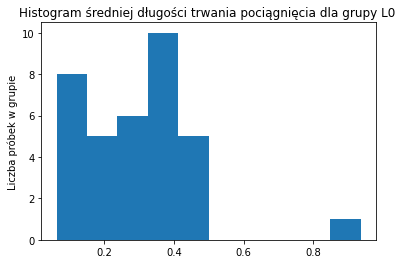

In [31]:
plt.hist(lev0['mean_str_dur'])
plt.title("Histogram średniej długości trwania pociągnięcia dla grupy L0 ")
plt.ylabel("Liczba próbek w grupie")
plt.show()

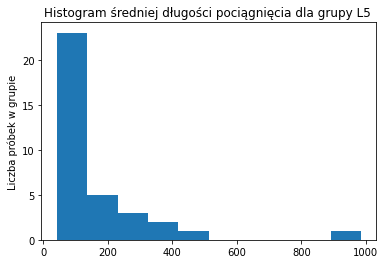

In [32]:
plt.hist(lev5['mean_str_len'])
plt.title("Histogram średniej długości pociągnięcia dla grupy L5 ")
plt.ylabel("Liczba próbek w grupie")
plt.show()

In [33]:
for column in filt_db_raw.columns[3:]:

  print('\033[30m'+column)
  shl0=stats.shapiro(lev0[column])
  shl1=stats.shapiro(lev1[column])
  shl2=stats.shapiro(lev2[column])
  shl3=stats.shapiro(lev3[column])
  shl4=stats.shapiro(lev4[column])
  shl5=stats.shapiro(lev5[column])
  if shl0.pvalue<0.05:
    print('\033[91m'+str(shl0))
  else:
    print('\033[30m'+str(shl0))
    
  if shl1.pvalue<0.05:
    print('\033[91m'+str(shl1))
  else:
    print('\033[30m'+str(shl1))

  if shl2.pvalue<0.05:
    print('\033[91m'+str(shl2))
  else:
    print('\033[30m'+str(shl2))

  if shl3.pvalue<0.05:
    print('\033[91m'+str(shl3))
  else:
    print('\033[30m'+str(shl3))

  if shl4.pvalue<0.05:
    print('\033[91m'+str(shl4))
  else:
    print('\033[30m'+str(shl4))

  if shl5.pvalue<0.05:
    print('\033[91m'+str(shl5))
  else:
    print('\033[30m'+str(shl5))
  print()
print('\033[30m')

acc_by_dur
ShapiroResult(statistic=0.9596326947212219, pvalue=0.22292841970920563)
ShapiroResult(statistic=0.9543085694313049, pvalue=0.1536380499601364)
ShapiroResult(statistic=0.9162421822547913, pvalue=0.011127609759569168)
ShapiroResult(statistic=0.9565942287445068, pvalue=0.18040265142917633)
ShapiroResult(statistic=0.9787017107009888, pvalue=0.7164589762687683)
ShapiroResult(statistic=0.9799953699111938, pvalue=0.7590218782424927)

mean_str_dur
ShapiroResult(statistic=0.882969856262207, pvalue=0.0014214370166882873)
ShapiroResult(statistic=0.8163026571273804, pvalue=4.3297324737068266e-05)
ShapiroResult(statistic=0.8431575298309326, pvalue=0.0001619091781321913)
ShapiroResult(statistic=0.6476143598556519, pvalue=6.277994657466479e-08)
ShapiroResult(statistic=0.8557975888252258, pvalue=0.00031303067225962877)
ShapiroResult(statistic=0.5251520872116089, pvalue=1.7332348889453897e-09)

std_str_dur
ShapiroResult(statistic=0.8970338106155396, pvalue=0.003294034395366907)
ShapiroResult

In [34]:
for column in filt_db_raw.columns[3:]:

  res=stats.levene(lev0[column],lev1[column],lev2[column],lev3[column],lev4[column],lev5[column])
  if res.pvalue<0.05:
    print('\033[91m'+column)
    print(str(res))
  else:
    print('\033[30m'+column)
    print(str(res))
  print('\033[30m')

acc_by_dur
LeveneResult(statistic=0.6458589000079863, pvalue=0.6649641020509633)

mean_str_dur
LeveneResult(statistic=1.5644590803136045, pvalue=0.17162798256254544)

std_str_dur
LeveneResult(statistic=1.195007863182652, pvalue=0.3128638086556511)

mean_str_len
LeveneResult(statistic=2.1318763608248132, pvalue=0.06305595041274874)

std_str_len
LeveneResult(statistic=2.4697095427127613, pvalue=0.03375167117064818)

min_acc
LeveneResult(statistic=1.0833528545975009, pvalue=0.3706972874257158)

max_acc
LeveneResult(statistic=5.075550078350646, pvalue=0.0002083856030653561)

mean_acc
LeveneResult(statistic=3.6624028695885436, pvalue=0.0033985471199651516)

zrc_acc
LeveneResult(statistic=0.23423827585623871, pvalue=0.9471212528215289)

mean_str_press
LeveneResult(statistic=0.826596749328726, pvalue=0.5320413529294157)

std_str_press
LeveneResult(statistic=1.4417039261669509, pvalue=0.21072979848948892)

mean_dir_change_vel
LeveneResult(statistic=2.2178718990099475, pvalue=0.0538683181587199

Parameters that wasn't proven to be unormal and have different variation in groups can be tested by classical ANOVA, rest will be tested by non-parametric Friedman test

# ANOVA

In [35]:
from statsmodels.stats.anova import AnovaRM

In [36]:

print('mean_str_press')
# mod = ols('mean_str_press ~ level',
#               data=filt_db_raw).fit()
aov_table = AnovaRM(data=filt_db_raw, depvar='mean_str_press', aggregate_func='mean',subject='owner', within=['level']).fit()
print(aov_table)
print()
print('acc_by_dur')
aov_table = AnovaRM(data=filt_db_raw, depvar='acc_by_dur', aggregate_func='mean',subject='owner', within=['level']).fit()
print(aov_table)
print()

mean_str_press
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
level  1.6563 5.0000 40.0000 0.1676


acc_by_dur
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
level  1.3259 5.0000 40.0000 0.2729




Test nieparametryczny Friedmanna porównujący rozkłady wszystkich parametrów parametrów

In [37]:
proven_diffrences=[]
for column in filt_db_raw.columns[3:]:

  res=stats.friedmanchisquare(lev0[column],lev1[column],lev2[column],lev3[column],lev4[column],lev5[column])
  if res.pvalue<0.05:
    proven_diffrences.append(column)
    print('\033[91m'+column)
    print(str(res))
  else:
    print('\033[30m'+column)
    print(str(res))
  print('\033[30m')

acc_by_dur
FriedmanchisquareResult(statistic=11.78367346938785, pvalue=0.03787524404825905)

mean_str_dur
FriedmanchisquareResult(statistic=25.024489795918385, pvalue=0.00013782487508968034)

std_str_dur
FriedmanchisquareResult(statistic=22.673469387755176, pvalue=0.0003896961050353168)

mean_str_len
FriedmanchisquareResult(statistic=35.0653061224491, pvalue=1.4601645622842194e-06)

std_str_len
FriedmanchisquareResult(statistic=24.22448979591843, pvalue=0.0001965726403570021)

min_acc
FriedmanchisquareResult(statistic=5.465306122449078, pvalue=0.36176519027123616)

max_acc
FriedmanchisquareResult(statistic=82.82040816326537, pvalue=2.1549444012838254e-16)

mean_acc
FriedmanchisquareResult(statistic=86.2326530612246, pvalue=4.151099885567649e-17)

zrc_acc
FriedmanchisquareResult(statistic=19.06275805119744, pvalue=0.0018710787327463794)

mean_str_press
FriedmanchisquareResult(statistic=9.742857142857247, pvalue=0.08285790201022362)

std_str_press
FriedmanchisquareResult(statistic=4.3387

Difference in groups was proven for all parameters except minimal acceleration, mean stroke pressure, standard deviation of stroke pressure.

# POST - HOC tests

In [42]:

for column in proven_diffrences:

  res=sp.posthoc_conover(filt_db_raw, val_col=column, group_col='level', p_adjust = 'holm')
  s1=res.style.applymap(lambda x: "background-color: red" if x<0.05 else "background-color: white")
  print(column)
  display(s1)
  print()
 

acc_by_dur


,L0,L1,L2,L3,L4,L5
L0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
L1,1.000000,1.000000,1.000000,1.000000,0.795423,1.000000
L2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
L3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
L4,1.000000,0.795423,1.000000,1.000000,1.000000,1.000000
L5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



mean_str_dur


,L0,L1,L2,L3,L4,L5
L0,1.000000,0.872582,0.564353,0.725154,0.564353,0.003598
L1,0.872582,1.000000,1.000000,1.000000,1.000000,0.407832
L2,0.564353,1.000000,1.000000,1.000000,1.000000,0.804574
L3,0.725154,1.000000,1.000000,1.000000,1.000000,0.599637
L4,0.564353,1.000000,1.000000,1.000000,1.000000,0.804574
L5,0.003598,0.407832,0.804574,0.599637,0.804574,1.000000



std_str_dur


,L0,L1,L2,L3,L4,L5
L0,1.000000,1.000000,1.000000,0.891904,0.420409,0.041628
L1,1.000000,1.000000,1.000000,1.000000,1.000000,0.620505
L2,1.000000,1.000000,1.000000,1.000000,1.000000,0.269891
L3,0.891904,1.000000,1.000000,1.000000,1.000000,1.000000
L4,0.420409,1.000000,1.000000,1.000000,1.000000,1.000000
L5,0.041628,0.620505,0.269891,1.000000,1.000000,1.000000



mean_str_len


,L0,L1,L2,L3,L4,L5
L0,1.000000,1.000000,1.000000,0.465540,0.651758,0.005124
L1,1.000000,1.000000,1.000000,1.000000,1.000000,0.275434
L2,1.000000,1.000000,1.000000,1.000000,1.000000,0.394976
L3,0.465540,1.000000,1.000000,1.000000,1.000000,1.000000
L4,0.651758,1.000000,1.000000,1.000000,1.000000,0.822789
L5,0.005124,0.275434,0.394976,1.000000,0.822789,1.000000



std_str_len


,L0,L1,L2,L3,L4,L5
L0,1.000000,1.000000,1.000000,0.444094,0.402747,0.083980
L1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
L2,1.000000,1.000000,1.000000,1.000000,1.000000,0.713545
L3,0.444094,1.000000,1.000000,1.000000,1.000000,1.000000
L4,0.402747,1.000000,1.000000,1.000000,1.000000,1.000000
L5,0.083980,1.000000,0.713545,1.000000,1.000000,1.000000



max_acc


,L0,L1,L2,L3,L4,L5
L0,1.000000,0.005860,0.025339,0.000000,0.000000,0.000000
L1,0.005860,1.000000,1.000000,0.033045,0.000001,0.000011
L2,0.025339,1.000000,1.000000,0.009047,0.000000,0.000001
L3,0.000000,0.033045,0.009047,1.000000,0.019779,0.061954
L4,0.000000,0.000001,0.000000,0.019779,1.000000,1.000000
L5,0.000000,0.000011,0.000001,0.061954,1.000000,1.000000



mean_acc


,L0,L1,L2,L3,L4,L5
L0,1.000000,0.817273,0.781464,0.000000,0.000000,0.000000
L1,0.817273,1.000000,0.842727,0.000002,0.000000,0.000000
L2,0.781464,0.842727,1.000000,0.000004,0.000000,0.000000
L3,0.000000,0.000002,0.000004,1.000000,0.349659,0.034718
L4,0.000000,0.000000,0.000000,0.349659,1.000000,0.817273
L5,0.000000,0.000000,0.000000,0.034718,0.817273,1.000000



zrc_acc


,L0,L1,L2,L3,L4,L5
L0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
L1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
L2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
L3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
L4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
L5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



mean_dir_change_vel


,L0,L1,L2,L3,L4,L5
L0,1.000000,1.000000,1.000000,0.071464,0.071464,0.155255
L1,1.000000,1.000000,1.000000,0.021159,0.021159,0.054186
L2,1.000000,1.000000,1.000000,0.442604,0.442604,0.718039
L3,0.071464,0.021159,0.442604,1.000000,1.000000,1.000000
L4,0.071464,0.021159,0.442604,1.000000,1.000000,1.000000
L5,0.155255,0.054186,0.718039,1.000000,1.000000,1.000000


# Analyzing drinking influence on person identification algorithms

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
# from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from datetime import datetime
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import numpy as np
import time, datetime, pickle

from sklearn.model_selection import KFold, GroupKFold, LeaveOneGroupOut, GroupShuffleSplit, GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

In [ ]:
def split_mono_set(array, labels,seed):
    traincX = []
    trainY = []
    testcX = []
    testY = []
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(array, labels):
        for ind in train_index:
            traincX.append(array[ind])
            trainY.append(labels[ind])
        for ind in test_index:
            testcX.append(array[ind])
            testY.append(labels[ind])
    return traincX,trainY,testcX,testY

In [ ]:
sober_data=filt_db_raw[(filt_db_raw['level']=='L0') | (filt_db_raw['level']=='L1') | (filt_db_raw['level']=='L2')]

In [ ]:
sober_data

,XX,level,owner,acc_by_dur,mean_str_dur,std_str_dur,mean_str_len,std_str_len,min_acc,max_acc,mean_acc,zrc_acc,mean_str_press,std_str_press,mean_dir_change_vel
10,10,L0,Natka,0.434783,0.408286,0.228566,93.117279,59.303936,-26041.666667,26463.487442,538.414922,105,582.023185,56.189432,30.270297
11,11,L0,Natka,0.450435,0.476500,0.316416,117.522892,82.795416,-31626.140074,33494.856564,500.706128,94,546.447907,75.047449,29.188290
12,12,L0,Natka,0.440916,0.486833,0.312701,117.820870,78.934223,-24598.692796,27124.456370,494.082967,104,490.207983,46.999700,29.427577
20,20,L2,Natka,0.410428,0.274889,0.192730,50.259958,35.295284,-28317.688963,41494.804125,784.103319,116,546.096007,85.021765,33.288688
21,21,L2,Natka,0.398318,0.350750,0.245820,59.428873,42.556388,-22183.607735,55555.555556,1604.651157,109,572.903009,30.193616,34.178772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,261,L1,Pawel,0.365540,0.369583,0.294599,62.562911,51.268599,-29686.490618,22110.018146,411.072271,159,681.340075,77.970947,30.582100
262,262,L1,Pawel,0.399722,0.367000,0.294117,52.013763,43.480859,-21438.593876,20803.782506,440.095007,133,665.004671,146.766126,32.123313
265,265,L0,Pawel,0.411765,0.272800,0.260273,46.931981,45.889248,-22881.273056,26690.718086,491.991847,151,696.555961,81.576547,31.991886
266,266,L0,Pawel,0.408665,0.132115,0.124953,21.105097,18.425399,-21614.583333,28656.400073,567.799717,172,649.196103,213.758048,31.493602


In [ ]:
sober_labels=sober_data['owner']
sober_features=sober_data.iloc[:,3:]

In [ ]:
sober_labels

10     Natka
11     Natka
12     Natka
20     Natka
21     Natka
       ...  
261    Pawel
262    Pawel
265    Pawel
266    Pawel
267    Pawel
Name: owner, Length: 105, dtype: object

In [ ]:
sober_features

,acc_by_dur,mean_str_dur,std_str_dur,mean_str_len,std_str_len,min_acc,max_acc,mean_acc,zrc_acc,mean_str_press,std_str_press,mean_dir_change_vel
10,0.434783,0.408286,0.228566,93.117279,59.303936,-26041.666667,26463.487442,538.414922,105,582.023185,56.189432,30.270297
11,0.450435,0.476500,0.316416,117.522892,82.795416,-31626.140074,33494.856564,500.706128,94,546.447907,75.047449,29.188290
12,0.440916,0.486833,0.312701,117.820870,78.934223,-24598.692796,27124.456370,494.082967,104,490.207983,46.999700,29.427577
13,0.450620,0.410571,0.241201,100.914054,65.545060,-34952.293544,46455.153508,489.557555,100,506.020613,48.417296,29.829399
20,0.410428,0.274889,0.192730,50.259958,35.295284,-28317.688963,41494.804125,784.103319,116,546.096007,85.021765,33.288688
...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.411765,0.272800,0.260273,46.931981,45.889248,-22881.273056,26690.718086,491.991847,151,696.555961,81.576547,31.991886
266,0.408665,0.132115,0.124953,21.105097,18.425399,-21614.583333,28656.400073,567.799717,172,649.196103,213.758048,31.493602
267,0.427708,0.062065,0.060678,11.090570,10.258034,-26696.018572,30577.777778,556.646091,163,646.957793,167.679769,32.361095
268,0.410153,0.152448,0.240040,22.947882,34.991719,-22006.566437,24957.264957,719.636786,164,627.095983,221.749669,30.870444


In [ ]:
seed=4
comp_sig=12

In [ ]:
len(train_X)

84

In [ ]:
sob_np_features=sober_features.to_numpy()
sob_np_labels=sober_labels.to_numpy()
le = LabelEncoder()
sob_np_labels=le.fit_transform(sob_np_labels)
train_X, train_Y, test_X, test_Y = split_mono_set(sob_np_features, sob_np_labels,seed)

In [ ]:
scaler_sig = StandardScaler()
train_X=scaler_sig.fit_transform(train_X)
pca_sig = PCA(svd_solver="randomized", n_components=comp_sig, whiten=True)
train_X=pca_sig.fit_transform(train_X)

test_X = scaler_sig.transform(np.array(test_X))
test_X = pca_sig.transform(test_X)

In [ ]:
class_model = SVC(kernel="rbf", C=30, gamma=0.008333333333333333,break_ties=False, random_state=3,decision_function_shape='ovr',probability=True)
class_model.fit(train_X, train_Y)
predictions = class_model.predict(test_X)
print(classification_report(test_Y, predictions, target_names=le.classes_))

              precision    recall  f1-score   support

       Kowal       1.00      1.00      1.00         3
      Kraken       0.00      0.00      0.00         2
      Lukasz       1.00      1.00      1.00         3
       Magda       1.00      1.00      1.00         2
     Natalia       1.00      1.00      1.00         3
       Natka       1.00      1.00      1.00         2
      Patryk       1.00      1.00      1.00         2
       Pawel       0.50      1.00      0.67         2
       Venom       1.00      1.00      1.00         2

    accuracy                           0.90        21
   macro avg       0.83      0.89      0.85        21
weighted avg       0.86      0.90      0.87        21



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Pipelines


In [ ]:
def svm_setup():

    classifier_svm = SVC(kernel="rbf",break_ties=False,decision_function_shape='ovr',probability=True)

    k_best = SelectKBest(f_classif)
    pca_sig = PCA( whiten=True)

    pipeline = Pipeline(steps=[
                               ('scaler', StandardScaler()), 
                               ('pca', pca_sig),
                               ('svm', classifier_svm)]) 

    # k = [8,10,12,14]
    C_values = [1, 2, 5, 10, 20, 30, 40]
    # svd_solver=['auto', 'randomized']
    pca_components = [8, 9, 10, 11, 12]
    gamma_values = [1/12] * np.array([0.001,0.01, 0.1, 1, 10])

    grid_search_parameters = {
                              'svm__C': C_values,
                              'pca__n_components': pca_components,
                              # 'pca__svd_solver': svd_solver,
                              'svm__gamma': gamma_values,
                              }
    
    # print(grid_search_parameters)
    xgboost = False
    
    return pipeline, grid_search_parameters 

In [ ]:
def svm_setup2():

    classifier_svm = SVC(kernel="rbf",break_ties=False,decision_function_shape='ovr',probability=True)

    k_best = SelectKBest(f_classif)
    ica_sig = FastICA(max_iter=400, whiten=True)

    pipeline = Pipeline(steps=[
                               ('scaler', StandardScaler()), 
                               ('ica', ica_sig),
                               ('svm', classifier_svm)]) 

    # k = [8,10,12,14]
    C_values = [ 10, 20, 30, 40, 60, 80]
    # ica_fun = ['logcosh', 'exp', 'cube']
    ica_components = [8, 9, 10, 11, 12]
    gamma_values = [1/12] * np.array([ 0.1, 1, 10, 50, 100])
    # algorithm{‘parallel’, ‘deflation’}
    # ica_alorithm=['parallel', 'deflation']

    grid_search_parameters = {
                              'svm__C': C_values,
                              'ica__n_components': ica_components,
                              'svm__gamma': gamma_values,
                              }
    
    # print(grid_search_parameters)
    xgboost = False
    
    return pipeline, grid_search_parameters 

In [ ]:
def train(X_data, y_data, pipeline, grid_search_parameters, cv, cv_groups, xgboost_flag):
    
    if xgboost_flag == True: 
        n_jobs = 1
    else:                       
        n_jobs = 16

    grid_search = GridSearchCV(pipeline, 
                               grid_search_parameters, 
                               cv = cv, 
                               n_jobs = n_jobs,
                               scoring = 'accuracy',
                               # iid = False,
                               return_train_score = True)
    start_time = time.time()

    grid_search.fit(X_data, y_data)
    # grid_search.fit(X_data, y_data, groups = cv_groups)

    pd_results = pd.DataFrame(grid_search.cv_results_)
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    params = grid_search.cv_results_['params']

    zipped = zip(means, stds, params)
    print('\nGrid search results:\n')
    for mean, std, params in sorted(zipped, key = lambda x: x[0]):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std, params))

    print('\nBest parameters:', grid_search.best_params_)
    # print('Test acc: ', grid_search.score(X_test, y_test))
    print('\nTrain CV acc: ',grid_search.best_score_)
    print('\nTime elapsed (hh:mm:ss): ', datetime.timedelta(seconds=(time.time() - start_time)))
    
    return grid_search

# Tuning with PCA

In [ ]:
sob_np_features=sober_features.to_numpy()
sob_np_labels=sober_labels.to_numpy()
le = LabelEncoder()
sob_np_labels=le.fit_transform(sob_np_labels)
train_X, train_Y, test_X, test_Y = split_mono_set(sob_np_features, sob_np_labels,seed)

In [ ]:
n_splits = 10

cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
# cv = GroupKFold(n_splits=n_splits)
# cv = LeaveOneGroupOut()
cv_groups = []

In [ ]:
start_time = time.time()

# # Logit
# pipeline, grid_search_parameters  = logit_setup()
# grid_search = train(X_train, y_train, pipeline, grid_search_parameters, cv, cv_groups, xgboost_flag = False)

# svm
pipeline, grid_search_parameters  = svm_setup()
grid_search_pca = train(train_X, train_Y, pipeline, grid_search_parameters, cv, cv_groups, xgboost_flag = False)

# # XGBoost 
# pipeline, grid_search_parameters  = xgboost_setup()
# grid_search = train(X_train, y_train, pipeline, grid_search_parameters, cv, cv_groups, xgboost_flag = True)

print('\n+++++++ Total computation time (hh:mm:ss): ', datetime.timedelta(seconds=(time.time() - start_time)))


Grid search results:

0.082 (+/-0.092) for {'pca__n_components': 8, 'svm__C': 1, 'svm__gamma': 8.333333333333333e-05}
0.082 (+/-0.092) for {'pca__n_components': 8, 'svm__C': 1, 'svm__gamma': 0.0008333333333333333}
0.082 (+/-0.092) for {'pca__n_components': 8, 'svm__C': 2, 'svm__gamma': 8.333333333333333e-05}
0.082 (+/-0.092) for {'pca__n_components': 8, 'svm__C': 2, 'svm__gamma': 0.0008333333333333333}
0.082 (+/-0.092) for {'pca__n_components': 8, 'svm__C': 5, 'svm__gamma': 8.333333333333333e-05}
0.082 (+/-0.092) for {'pca__n_components': 8, 'svm__C': 5, 'svm__gamma': 0.0008333333333333333}
0.082 (+/-0.092) for {'pca__n_components': 8, 'svm__C': 10, 'svm__gamma': 8.333333333333333e-05}
0.082 (+/-0.092) for {'pca__n_components': 8, 'svm__C': 20, 'svm__gamma': 8.333333333333333e-05}
0.082 (+/-0.092) for {'pca__n_components': 8, 'svm__C': 30, 'svm__gamma': 8.333333333333333e-05}
0.082 (+/-0.092) for {'pca__n_components': 8, 'svm__C': 40, 'svm__gamma': 8.333333333333333e-05}
0.082 (+/-0.0

# Tuning with ICA

In [ ]:
sob_np_features=sober_features.to_numpy()
sob_np_labels=sober_labels.to_numpy()
le = LabelEncoder()
sob_np_labels=le.fit_transform(sob_np_labels)
train_X, train_Y, test_X, test_Y = split_mono_set(sob_np_features, sob_np_labels,seed)

In [ ]:
n_splits = 10

cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
# cv = GroupKFold(n_splits=n_splits)
# cv = LeaveOneGroupOut()
cv_groups = []

In [ ]:
start_time = time.time()

# # Logit
# pipeline, grid_search_parameters  = logit_setup()
# grid_search = train(X_train, y_train, pipeline, grid_search_parameters, cv, cv_groups, xgboost_flag = False)

# svm
pipeline, grid_search_parameters  = svm_setup2()
grid_search_ica = train(train_X, train_Y, pipeline, grid_search_parameters, cv, cv_groups, xgboost_flag = False)

# # XGBoost 
# pipeline, grid_search_parameters  = xgboost_setup()
# grid_search = train(X_train, y_train, pipeline, grid_search_parameters, cv, cv_groups, xgboost_flag = True)

print('\n+++++++ Total computation time (hh:mm:ss): ', datetime.timedelta(seconds=(time.time() - start_time)))


Grid search results:

0.082 (+/-0.092) for {'ica__n_components': 8, 'svm__C': 10, 'svm__gamma': 0.008333333333333333}
0.082 (+/-0.092) for {'ica__n_components': 8, 'svm__C': 20, 'svm__gamma': 0.008333333333333333}
0.082 (+/-0.092) for {'ica__n_components': 8, 'svm__C': 30, 'svm__gamma': 0.008333333333333333}
0.082 (+/-0.092) for {'ica__n_components': 9, 'svm__C': 10, 'svm__gamma': 0.008333333333333333}
0.082 (+/-0.092) for {'ica__n_components': 9, 'svm__C': 20, 'svm__gamma': 0.008333333333333333}
0.082 (+/-0.092) for {'ica__n_components': 9, 'svm__C': 30, 'svm__gamma': 0.008333333333333333}
0.082 (+/-0.092) for {'ica__n_components': 10, 'svm__C': 10, 'svm__gamma': 0.008333333333333333}
0.082 (+/-0.092) for {'ica__n_components': 10, 'svm__C': 20, 'svm__gamma': 0.008333333333333333}
0.082 (+/-0.092) for {'ica__n_components': 10, 'svm__C': 30, 'svm__gamma': 0.008333333333333333}
0.082 (+/-0.092) for {'ica__n_components': 11, 'svm__C': 10, 'svm__gamma': 0.008333333333333333}
0.082 (+/-0.0

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


# Both algorithm tests

# PCA test

In [ ]:
# 0.855 (+/-0.100) for {'pca__n_components': 10, 'svm__C': 2, 'svm__gamma': 0.08333333333333333}

In [ ]:
C_value = grid_search_pca.best_params_['svm__C']
components = grid_search_pca.best_params_['pca__n_components']
gamma_value = grid_search_pca.best_params_['svm__gamma']

In [ ]:
# C_value = 2
# components = 10
# gamma_value = 0.08333333333333333

In [ ]:
res=[]
for i in range(10):
  seed=i
  sob_np_features=sober_features.to_numpy()
  sob_np_labels=sober_labels.to_numpy()
  le = LabelEncoder()
  sob_np_labels=le.fit_transform(sob_np_labels)
  train_X, train_Y, test_X, test_Y = split_mono_set(sob_np_features, sob_np_labels,seed)
  scaler_sig = StandardScaler()
  train_X=scaler_sig.fit_transform(train_X)
  pca_sig = PCA(svd_solver="randomized", n_components=components, whiten=True)
  train_X=pca_sig.fit_transform(train_X)

  test_X = scaler_sig.transform(np.array(test_X))
  test_X = pca_sig.transform(test_X)
  class_model = SVC(kernel="rbf", C=C_value, gamma=gamma_value,break_ties=False,decision_function_shape='ovr',probability=True)
  class_model.fit(train_X, train_Y)
  predictions = class_model.predict(test_X)
  # print(classification_report(test_Y, predictions, target_names=le.classes_))
  res.append(f1_score(test_Y, predictions,average='micro'))

In [ ]:
print(np.mean(np.array(res)))
print(np.std(np.array(res)))

0.8571428571428571
0.05634361698190109


In [ ]:
res

[0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.9523809523809523,
 0.9523809523809523,
 0.8571428571428571,
 0.7619047619047619,
 0.8095238095238095,
 0.8095238095238095]

              precision    recall  f1-score   support

       Kowal       1.00      1.00      1.00         3
      Kraken       0.67      1.00      0.80         2
      Lukasz       1.00      1.00      1.00         3
       Magda       1.00      1.00      1.00         3
     Natalia       0.67      0.67      0.67         3
       Natka       1.00      1.00      1.00         3
      Patryk       0.67      0.67      0.67         3
       Pawel       1.00      0.67      0.80         3
       Venom       1.00      1.00      1.00         3

    accuracy                           0.88        26
   macro avg       0.89      0.89      0.88        26
weighted avg       0.90      0.88      0.88        26



# ICA test

In [ ]:
C_value = grid_search_ica.best_params_['svm__C']
components = grid_search_ica.best_params_['ica__n_components']
gamma_value = grid_search_ica.best_params_['svm__gamma']

In [ ]:
res=[]
for i in range(10):
  seed=i
  sob_np_features=sober_features.to_numpy()
  sob_np_labels=sober_labels.to_numpy()
  le = LabelEncoder()
  sob_np_labels=le.fit_transform(sob_np_labels)
  train_X, train_Y, test_X, test_Y = split_mono_set(sob_np_features, sob_np_labels,seed)
  scaler_sig = StandardScaler()
  train_X=scaler_sig.fit_transform(train_X)
  pca_sig = FastICA(n_components = components, tol=10**(-1) , max_iter=800, whiten=True)
  train_X=pca_sig.fit_transform(train_X)

  test_X = scaler_sig.transform(np.array(test_X))
  test_X = pca_sig.transform(test_X)
  class_model = SVC(kernel="rbf", C=C_value, gamma=gamma_value,break_ties=False,decision_function_shape='ovr',probability=True)
  class_model.fit(train_X, train_Y)
  predictions = class_model.predict(test_X)
  print(classification_report(test_Y, predictions, target_names=le.classes_))
  res.append(f1_score(test_Y, predictions,average='micro'))

              precision    recall  f1-score   support

       Kowal       0.75      1.00      0.86         3
      Kraken       1.00      0.50      0.67         2
      Lukasz       1.00      1.00      1.00         3
       Magda       1.00      1.00      1.00         2
     Natalia       0.67      0.67      0.67         3
       Natka       1.00      1.00      1.00         2
      Patryk       1.00      0.50      0.67         2
       Pawel       0.67      1.00      0.80         2
       Venom       1.00      1.00      1.00         2

    accuracy                           0.86        21
   macro avg       0.90      0.85      0.85        21
weighted avg       0.88      0.86      0.85        21

              precision    recall  f1-score   support

       Kowal       1.00      1.00      1.00         3
      Kraken       1.00      0.50      0.67         2
      Lukasz       0.75      1.00      0.86         3
       Magda       1.00      1.00      1.00         2
     Natalia       0.75 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
print(np.mean(np.array(res)))
print(np.std(np.array(res)))

0.8666666666666666
0.05128728387747145


# Drinking comparison


Prepare drunk data

In [ ]:
def test_pca(level):
  

  C_value = grid_search_pca.best_params_['svm__C']
  components = grid_search_pca.best_params_['pca__n_components']
  gamma_value = grid_search_pca.best_params_['svm__gamma']

  res=[]
  for i in range(10):
    drunk_data=filt_db_raw[(filt_db_raw['level']==level)]
    drunk_labels=drunk_data['owner']
    drunk_features=drunk_data.iloc[:,3:]
    drunk_np_features=drunk_features.to_numpy()
    drunk_np_labels=drunk_labels.to_numpy()
    test_drunk_X = drunk_np_features
    test_drunk_Y = drunk_np_labels
    seed=i
    sob_np_features=sober_features.to_numpy()
    sob_np_labels=sober_labels.to_numpy()
    le = LabelEncoder()
    sob_np_labels=le.fit_transform(sob_np_labels)
    train_X, train_Y, test_X, test_Y = split_mono_set(sob_np_features, sob_np_labels,seed)
    scaler_sig = StandardScaler()
    train_X=scaler_sig.fit_transform(train_X)
    pca_sig = PCA(svd_solver="randomized", n_components=components, whiten=True)
    train_X=pca_sig.fit_transform(train_X)

    test_X = scaler_sig.transform(np.array(test_X))
    test_X = pca_sig.transform(test_X)
    class_model = SVC(kernel="rbf", C=C_value, gamma=gamma_value,break_ties=False,decision_function_shape='ovr',probability=True)
    class_model.fit(train_X, train_Y)
    # predictions = class_model.predict(test_X)

    test_drunk_Y = le.transform(test_drunk_Y)
    test_drunk_X = scaler_sig.transform(np.array(test_drunk_X))
    test_drunk_X = pca_sig.transform(test_drunk_X)

    predictions = class_model.predict(test_drunk_X)
    # print(classification_report(test_Y, predictions, target_names=le.classes_))
    # res.append(f1_score(test_Y, predictions,average='micro'))
    res.append(f1_score(test_drunk_Y, predictions,average='micro'))
  # print(res)
  print(np.mean(np.array(res)))
  print(np.std(np.array(res))) 

In [ ]:
def test_ica(level):
  

  C_value = grid_search_ica.best_params_['svm__C']
  components = grid_search_ica.best_params_['ica__n_components']
  gamma_value = grid_search_ica.best_params_['svm__gamma']

  res=[]
  for i in range(10):
    drunk_data=filt_db_raw[(filt_db_raw['level']==level)]
    drunk_labels=drunk_data['owner']
    drunk_features=drunk_data.iloc[:,3:]
    drunk_np_features=drunk_features.to_numpy()
    drunk_np_labels=drunk_labels.to_numpy()
    test_drunk_X = drunk_np_features
    test_drunk_Y = drunk_np_labels
    seed=i
    sob_np_features=sober_features.to_numpy()
    sob_np_labels=sober_labels.to_numpy()
    le = LabelEncoder()
    sob_np_labels=le.fit_transform(sob_np_labels)
    train_X, train_Y, test_X, test_Y = split_mono_set(sob_np_features, sob_np_labels,seed)
    scaler_sig = StandardScaler()
    train_X=scaler_sig.fit_transform(train_X)
    
    pca_sig = FastICA(n_components = components, tol=10**(-1) , max_iter=800, whiten=True)
    train_X=pca_sig.fit_transform(train_X)

    test_X = scaler_sig.transform(np.array(test_X))
    test_X = pca_sig.transform(test_X)
    class_model = SVC(kernel="rbf", C=C_value, gamma=gamma_value,break_ties=False,decision_function_shape='ovr',probability=True)
    class_model.fit(train_X, train_Y)
    # predictions = class_model.predict(test_X)

    test_drunk_Y = le.transform(test_drunk_Y)
    test_drunk_X = scaler_sig.transform(np.array(test_drunk_X))
    test_drunk_X = pca_sig.transform(test_drunk_X)

    predictions = class_model.predict(test_drunk_X)
    # print(classification_report(test_Y, predictions, target_names=le.classes_))
    # res.append(f1_score(test_Y, predictions,average='micro'))
    res.append(f1_score(test_drunk_Y, predictions,average='micro'))
  # print(res)
  print(np.mean(np.array(res)))
  print(np.std(np.array(res))) 

In [ ]:
test_ica('L5')

0.4057142857142858
0.04571428571428571


In [ ]:
drunk_data=filt_db_raw[(filt_db_raw['level']=='L3')]

In [ ]:
drunk_labels=drunk_data['owner']
drunk_features=drunk_data.iloc[:,3:]

In [ ]:
drunk_np_features=drunk_features.to_numpy()
drunk_np_labels=drunk_labels.to_numpy()
test_drunk_X = drunk_np_features
test_drunk_Y = drunk_np_labels

In [ ]:
test_drunk_Y

array(['Natka', 'Natka', 'Natka', 'Natka', 'Natka', 'Patryk', 'Patryk',
       'Patryk', 'Patryk', 'Patryk', 'Magda', 'Magda', 'Magda', 'Kraken',
       'Kraken', 'Kraken', 'Kraken', 'Kraken', 'Venom', 'Venom', 'Venom',
       'Venom', 'Venom', 'Kowal', 'Kowal', 'Kowal', 'Kowal', 'Kowal',
       'Lukasz', 'Lukasz', 'Lukasz', 'Lukasz', 'Lukasz', 'Natalia',
       'Natalia', 'Natalia', 'Natalia', 'Natalia', 'Pawel', 'Pawel',
       'Pawel', 'Pawel'], dtype=object)

In [ ]:
C_value = grid_search_pca.best_params_['svm__C']
components = grid_search_pca.best_params_['pca__n_components']
gamma_value = grid_search_pca.best_params_['svm__gamma']
sob_np_features=sober_features.to_numpy()
sob_np_labels=sober_labels.to_numpy()
le = LabelEncoder()
sob_np_labels=le.fit_transform(sob_np_labels)
train_X, train_Y, test_X, test_Y = split_mono_set(sob_np_features, sob_np_labels,seed)
scaler_sig = StandardScaler()
train_X=scaler_sig.fit_transform(train_X)
pca_sig = PCA(svd_solver="randomized", n_components=components, whiten=True)
train_X=pca_sig.fit_transform(train_X)

test_X = scaler_sig.transform(np.array(test_X))
test_X = pca_sig.transform(test_X)
class_model = SVC(kernel="rbf", C=C_value, gamma=gamma_value,break_ties=False,decision_function_shape='ovr',probability=True)
class_model.fit(train_X, train_Y)
predictions = class_model.predict(test_X)
print(classification_report(test_Y, predictions, target_names=le.classes_))

              precision    recall  f1-score   support

       Kowal       1.00      0.67      0.80         3
      Kraken       1.00      1.00      1.00         2
      Lukasz       0.75      1.00      0.86         3
       Magda       1.00      1.00      1.00         3
     Natalia       0.00      0.00      0.00         3
       Natka       1.00      1.00      1.00         3
      Patryk       0.50      0.67      0.57         3
       Pawel       1.00      1.00      1.00         3
       Venom       1.00      1.00      1.00         3

    accuracy                           0.81        26
   macro avg       0.81      0.81      0.80        26
weighted avg       0.80      0.81      0.80        26



In [ ]:
test_drunk_Y = le.transform(test_drunk_Y)
test_drunk_X = scaler_sig.transform(np.array(test_drunk_X))
test_drunk_X = pca_sig.transform(test_drunk_X)

predictions = class_model.predict(test_drunk_X)
# print(classification_report(test_Y, predictions, target_names=le.classes_))
# res.append(f1_score(test_Y, predictions,average='micro'))
f1_score(test_drunk_Y, predictions,average='micro')

0.5476190476190477